In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='darkgrid')

#pre-processing method
from sklearn.model_selection import train_test_split

#the regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

#methods and classes for evaluation
from sklearn import metrics
from math import sqrt
from sklearn.model_selection import cross_validate
import time

In [2]:
df = pd.read_csv(r"D:\Nihal Kumar\Study_Notes\Part_1_GL\Practice\Projects\Ensemble_Techniques\ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")
df.head()

month        town flat_type block        street_name storey_range  \
0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  
0      232000.0  
1      250000.0  
2      262000.0  
3      265000.0  
4      265000.0

In [3]:
df.isna().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

In [4]:
df

month        town  flat_type block        street_name storey_range  \
0       2017-01  ANG MO KIO     2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1       2017-01  ANG MO KIO     3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2       2017-01  ANG MO KIO     3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3       2017-01  ANG MO KIO     3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4       2017-01  ANG MO KIO     3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   
...         ...         ...        ...   ...                ...          ...   
165036  2023-10      YISHUN     5 ROOM  513B       YISHUN ST 51     10 TO 12   
165037  2023-10      YISHUN  EXECUTIVE   406       YISHUN AVE 6     07 TO 09   
165038  2023-10      YISHUN  EXECUTIVE   391       YISHUN AVE 6     04 TO 06   
165039  2023-10      YISHUN  EXECUTIVE   643       YISHUN ST 61     10 TO 12   
165040  2023-10      YISHUN  EXECUTIVE   641       YISHUN ST 61     07 TO 09   

        floor_area_sqm      flat_model  lease_commence_date  \
0                 44.0        Improved                 1979   
1                 67.0  New Generation                 1978   
2                 67.0  New Generation                 1980   
3                 68.0  New Generation                 1980   
4                 67.0  New Generation                 1980   
...                ...             ...                  ...   
165036           113.0        Improved                 2018   
165037           148.0      Maisonette                 1988   
165038           142.0       Apartment                 1988   
165039           142.0       Apartment                 1987   
165040           164.0       Apartment                 1992   

           remaining_lease  resale_price  
0       61 years 04 months      232000.0  
1       60 years 07 months      250000.0  
2       62 years 05 months      262000.0  
3        62 years 01 month      265000.0  
4       62 years 05 months      265000.0  
...                    ...           ...  
165036  93 years 05 months      715000.0  
165037  63 years 11 months      830000.0  
165038  63 years 08 months      753000.0  
165039            63 years      808000.0  
165040  67 years 08 months      980000.0  

[165041 rows x 11 columns]

In [5]:
numeric_col = df.columns[pd.Series(df.columns).apply(lambda x : df[x].dtype == 'float64')]
plt.figure(figsize=(20,3))
j=1
for i in numeric_col:
    plt.subplot(1,2,j)
    sns.boxplot(df[i])
    j += 1
    

C:\Users\uie72014\AppData\Local\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\uie72014\AppData\Local\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


In [6]:
from datetime import datetime
df.month = df.month.apply(lambda x: datetime.strptime(x, "%Y-%m"))

In [7]:
remaining_years = df.remaining_lease.apply(lambda x: int(x[0:2]))
lease_duration = (df.month.apply(lambda x: x.year)-df.lease_commence_date)+remaining_years
lease_duration.value_counts()

99     91865
98     72590
100      586
dtype: int64

In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
encoded_df = pd.DataFrame()
object_col = df.columns[pd.Series(df.columns).apply(lambda x:df[x].dtype == 'O')]
for i in df.columns:
    if i in object_col:
        encoded_df[i] = le.fit_transform(df[i])
    else:
        encoded_df[i] = df[i]

In [9]:
encoded_df.dtypes

month                  datetime64[ns]
town                            int32
flat_type                       int32
block                           int32
street_name                     int32
storey_range                    int32
floor_area_sqm                float64
flat_model                      int32
lease_commence_date             int64
remaining_lease                 int32
resale_price                  float64
dtype: object

In [10]:
#convert data type of categorical columns as 'category' type
for i in df.columns:
    if df[i].dtype == 'O':
        encoded_df[i] = encoded_df[i].astype('category')
    else:
        pass

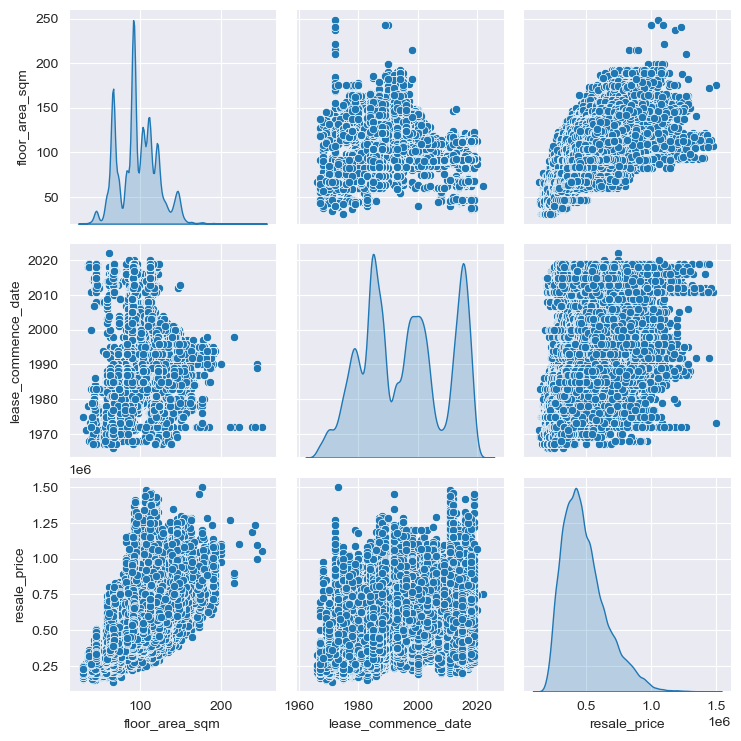

In [11]:
sns.pairplot(df,diag_kind='kde')
plt.show()

In [12]:
encoded_df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')

In [13]:
#drop month and lease column
X = encoded_df.drop(columns=['month','remaining_lease','resale_price'])
y = encoded_df.resale_price

In [14]:
X_train, X_test,y_train,y_test = train_test_split(X,y, random_state= 1)

In [15]:
#train and evaluate models
def fit_n_print(model,X_train,X_test,y_train,y_test):
    start = time.time()
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    r2 = metrics.r2_score(y_test,pred)
    rmse = sqrt(metrics.mean_squared_error(y_test,pred))
    rmsle = sqrt(metrics.mean_squared_log_error(y_test,pred))
    scorer = {'r2' : metrics.make_scorer(metrics.r2_score),
             'mse':metrics.make_scorer(metrics.mean_squared_error),
             'msle':metrics.make_scorer(metrics.mean_squared_log_error)}
    cv = cross_validate(model,X_train,y_train,cv=10,scoring=scorer)
    r2_cv = cv['test_r2'].mean()
    rmse_cv = np.mean([sqrt(mse) for mse in cv['test_mse']])
    rmsle_cv = np.mean([sqrt(msle) for msle in cv['test_msle']])
    end = time.time()
    duration = end - start
    return r2, rmse, rmsle, r2_cv, rmse_cv,rmsle_cv, duration, pred

In [16]:
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state = 1)
br = BaggingRegressor(random_state = 1)
rf = RandomForestRegressor(random_state = 1, n_estimators=100)
gb = GradientBoostingRegressor(random_state = 1,n_estimators=100)

result = {}
for model, name in zip([lr,dt,br,rf,gb],['Linear Regression','Decision Tree',
                                          'Bagging Ensemble','Random Forest',
                                          'Gradient Boost Ensemble']):
    result[name] = fit_n_print(model,X_train,X_test,y_train,y_test)
                      

In [17]:
result1 = pd.DataFrame(np.array(list(result.values()))[:,:-1],
                        columns=['R Squared','MSE','MSLE','R2 CV','RMSE CV','RMSLE CV','Elapsed'],
                        index = result.keys())
result1.index.name = 'Model'
result1

C:\Users\uie72014\AppData\Local\Temp\ipykernel_22472\2690620341.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result1 = pd.DataFrame(np.array(list(result.values()))[:,:-1],


R Squared            MSE      MSLE     R2 CV  \
Model                                                                  
Linear Regression        0.563239  111856.133447  0.216082  0.564746   
Decision Tree            0.816385    72525.80699  0.148671  0.811235   
Bagging Ensemble         0.856914     64023.0933  0.133048   0.85487   
Random Forest            0.862333   62799.080898  0.130737   0.86068   
Gradient Boost Ensemble  0.778966   79573.340637  0.154871  0.778483   

                               RMSE CV  RMSLE CV     Elapsed  
Model                                                         
Linear Regression        111525.863314  0.215852    0.772806  
Decision Tree             73442.131017  0.150523    4.884203  
Bagging Ensemble          64397.302172  0.133839   32.731538  
Random Forest              63094.55996  0.131374   338.73112  
Gradient Boost Ensemble   79559.602467  0.154477  105.434681

In [18]:
cat_col = X.columns[pd.Series(X.columns).apply(lambda x:X[x].dtype.name == 'category')]
#check the cardinality of the columns
for i in cat_col:
    print(i,'=>',len(X[i].value_counts()))

town => 26
flat_type => 7
block => 2686
street_name => 565
storey_range => 17
flat_model => 21


In [19]:
one_hot_X = X.drop(columns = ['block','street_name'])
one_hot_X = pd.get_dummies(one_hot_X, drop_first = True)
one_hot_X.shape
X_train,X_test,y_train,y_test = train_test_split(one_hot_X,y, random_state = 1)

In [20]:
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state = 1)
br = BaggingRegressor(random_state = 1)
rf = RandomForestRegressor(random_state = 1, n_estimators=100)
gb = GradientBoostingRegressor(random_state = 1,n_estimators=100)
xgb = XGBRegressor()
cgb = CatBoostRegressor()
lgb = LGBMRegressor()

result = {}
for model, name in zip([lr,dt,br,rf,gb,xgb,cgb,lgb],['Linear Regression','Decision Tree',
                                          'Bagging Ensemble','Random Forest',
                                          'Gradient Boost Ensemble','Xgboost','Catboost','LightGB']):
    result[name] = fit_n_print(model,X_train,X_test,y_train,y_test)
                      

Learning rate set to 0.087663
0:	learn: 160541.5875101	total: 206ms	remaining: 3m 25s
1:	learn: 153161.3863992	total: 218ms	remaining: 1m 49s
2:	learn: 146745.3669976	total: 230ms	remaining: 1m 16s
3:	learn: 141060.8644905	total: 242ms	remaining: 1m
4:	learn: 136039.7552947	total: 254ms	remaining: 50.5s
5:	learn: 131588.3780678	total: 263ms	remaining: 43.6s
6:	learn: 127561.8671223	total: 272ms	remaining: 38.6s
7:	learn: 124002.8858059	total: 281ms	remaining: 34.8s
8:	learn: 120761.8060720	total: 290ms	remaining: 31.9s
9:	learn: 117883.4768043	total: 299ms	remaining: 29.6s
10:	learn: 115319.9722253	total: 307ms	remaining: 27.6s
11:	learn: 112950.0064515	total: 316ms	remaining: 26s
12:	learn: 110888.7342448	total: 326ms	remaining: 24.7s
13:	learn: 109053.7853438	total: 335ms	remaining: 23.6s
14:	learn: 107262.0834409	total: 344ms	remaining: 22.6s
15:	learn: 105521.6436072	total: 353ms	remaining: 21.7s
16:	learn: 103985.5179733	total: 361ms	remaining: 20.9s
17:	learn: 102577.1900454	tota

149:	learn: 69218.9465557	total: 1.45s	remaining: 8.24s
150:	learn: 69164.9955762	total: 1.46s	remaining: 8.22s
151:	learn: 69102.4951618	total: 1.47s	remaining: 8.2s
152:	learn: 69053.7035487	total: 1.48s	remaining: 8.18s
153:	learn: 69002.8541370	total: 1.49s	remaining: 8.16s
154:	learn: 68942.1889600	total: 1.49s	remaining: 8.14s
155:	learn: 68903.9019533	total: 1.5s	remaining: 8.12s
156:	learn: 68852.5117083	total: 1.51s	remaining: 8.1s
157:	learn: 68818.9015889	total: 1.52s	remaining: 8.08s
158:	learn: 68758.1931295	total: 1.52s	remaining: 8.06s
159:	learn: 68705.4985224	total: 1.53s	remaining: 8.04s
160:	learn: 68650.0758723	total: 1.54s	remaining: 8.02s
161:	learn: 68596.5808651	total: 1.55s	remaining: 8.01s
162:	learn: 68555.0719296	total: 1.56s	remaining: 7.99s
163:	learn: 68476.4073521	total: 1.56s	remaining: 7.97s
164:	learn: 68418.4182796	total: 1.57s	remaining: 7.96s
165:	learn: 68380.0420374	total: 1.58s	remaining: 7.94s
166:	learn: 68343.6783089	total: 1.59s	remaining: 7

300:	learn: 64601.8397426	total: 2.7s	remaining: 6.26s
301:	learn: 64588.2849173	total: 2.71s	remaining: 6.25s
302:	learn: 64569.3226748	total: 2.71s	remaining: 6.24s
303:	learn: 64550.5100595	total: 2.72s	remaining: 6.23s
304:	learn: 64542.0064302	total: 2.73s	remaining: 6.22s
305:	learn: 64524.0702479	total: 2.74s	remaining: 6.21s
306:	learn: 64515.4057786	total: 2.75s	remaining: 6.2s
307:	learn: 64503.4064919	total: 2.75s	remaining: 6.19s
308:	learn: 64482.5703861	total: 2.76s	remaining: 6.18s
309:	learn: 64471.2276257	total: 2.77s	remaining: 6.17s
310:	learn: 64457.8545728	total: 2.78s	remaining: 6.15s
311:	learn: 64445.9378475	total: 2.79s	remaining: 6.14s
312:	learn: 64427.7663955	total: 2.79s	remaining: 6.13s
313:	learn: 64414.3305034	total: 2.8s	remaining: 6.12s
314:	learn: 64403.8394924	total: 2.81s	remaining: 6.11s
315:	learn: 64386.8782232	total: 2.82s	remaining: 6.1s
316:	learn: 64369.0832595	total: 2.82s	remaining: 6.08s
317:	learn: 64359.5150473	total: 2.83s	remaining: 6.

455:	learn: 62679.8564015	total: 3.95s	remaining: 4.71s
456:	learn: 62668.7964578	total: 3.96s	remaining: 4.7s
457:	learn: 62660.4242480	total: 3.97s	remaining: 4.69s
458:	learn: 62648.5263756	total: 3.97s	remaining: 4.68s
459:	learn: 62637.4413195	total: 3.98s	remaining: 4.67s
460:	learn: 62622.7678188	total: 3.99s	remaining: 4.67s
461:	learn: 62616.9110072	total: 4s	remaining: 4.66s
462:	learn: 62607.9053319	total: 4.01s	remaining: 4.65s
463:	learn: 62595.7355058	total: 4.01s	remaining: 4.64s
464:	learn: 62586.2216424	total: 4.02s	remaining: 4.63s
465:	learn: 62575.4936179	total: 4.03s	remaining: 4.62s
466:	learn: 62569.3887842	total: 4.04s	remaining: 4.61s
467:	learn: 62561.9378080	total: 4.05s	remaining: 4.6s
468:	learn: 62550.6648574	total: 4.05s	remaining: 4.59s
469:	learn: 62538.2421765	total: 4.06s	remaining: 4.58s
470:	learn: 62527.9149473	total: 4.07s	remaining: 4.57s
471:	learn: 62518.0082978	total: 4.08s	remaining: 4.56s
472:	learn: 62507.1155839	total: 4.09s	remaining: 4.5

610:	learn: 61516.3200643	total: 5.2s	remaining: 3.31s
611:	learn: 61508.3617061	total: 5.21s	remaining: 3.3s
612:	learn: 61504.0137972	total: 5.21s	remaining: 3.29s
613:	learn: 61499.3711027	total: 5.22s	remaining: 3.28s
614:	learn: 61493.1576803	total: 5.23s	remaining: 3.27s
615:	learn: 61486.4327247	total: 5.24s	remaining: 3.27s
616:	learn: 61482.1617484	total: 5.25s	remaining: 3.26s
617:	learn: 61476.5362712	total: 5.25s	remaining: 3.25s
618:	learn: 61469.6852066	total: 5.26s	remaining: 3.24s
619:	learn: 61466.0481200	total: 5.27s	remaining: 3.23s
620:	learn: 61461.8969507	total: 5.28s	remaining: 3.22s
621:	learn: 61452.1474958	total: 5.29s	remaining: 3.21s
622:	learn: 61444.3884546	total: 5.29s	remaining: 3.2s
623:	learn: 61437.3470604	total: 5.3s	remaining: 3.19s
624:	learn: 61432.6198227	total: 5.31s	remaining: 3.19s
625:	learn: 61429.2126347	total: 5.32s	remaining: 3.18s
626:	learn: 61423.0336756	total: 5.33s	remaining: 3.17s
627:	learn: 61414.1528059	total: 5.33s	remaining: 3.

760:	learn: 60733.7790887	total: 6.41s	remaining: 2.01s
761:	learn: 60731.7416212	total: 6.42s	remaining: 2s
762:	learn: 60729.7688058	total: 6.42s	remaining: 2s
763:	learn: 60722.4625605	total: 6.43s	remaining: 1.99s
764:	learn: 60718.1559199	total: 6.44s	remaining: 1.98s
765:	learn: 60710.5061588	total: 6.45s	remaining: 1.97s
766:	learn: 60708.0483381	total: 6.46s	remaining: 1.96s
767:	learn: 60702.7047179	total: 6.47s	remaining: 1.95s
768:	learn: 60700.4244273	total: 6.48s	remaining: 1.95s
769:	learn: 60696.5915791	total: 6.49s	remaining: 1.94s
770:	learn: 60693.7182731	total: 6.49s	remaining: 1.93s
771:	learn: 60687.2025616	total: 6.5s	remaining: 1.92s
772:	learn: 60683.9988854	total: 6.51s	remaining: 1.91s
773:	learn: 60678.3117512	total: 6.52s	remaining: 1.9s
774:	learn: 60674.5415598	total: 6.53s	remaining: 1.89s
775:	learn: 60669.7521645	total: 6.53s	remaining: 1.89s
776:	learn: 60667.8136521	total: 6.54s	remaining: 1.88s
777:	learn: 60663.7795028	total: 6.55s	remaining: 1.87s


909:	learn: 60169.8035033	total: 7.65s	remaining: 756ms
910:	learn: 60165.3509426	total: 7.66s	remaining: 748ms
911:	learn: 60162.9693252	total: 7.66s	remaining: 740ms
912:	learn: 60158.7851638	total: 7.67s	remaining: 731ms
913:	learn: 60156.2221925	total: 7.68s	remaining: 723ms
914:	learn: 60152.8906276	total: 7.69s	remaining: 714ms
915:	learn: 60148.8610071	total: 7.7s	remaining: 706ms
916:	learn: 60146.9244154	total: 7.7s	remaining: 697ms
917:	learn: 60144.7357447	total: 7.71s	remaining: 689ms
918:	learn: 60141.2273286	total: 7.72s	remaining: 681ms
919:	learn: 60135.9470138	total: 7.73s	remaining: 672ms
920:	learn: 60129.7203458	total: 7.74s	remaining: 664ms
921:	learn: 60127.3096561	total: 7.75s	remaining: 655ms
922:	learn: 60124.0850940	total: 7.75s	remaining: 647ms
923:	learn: 60121.4889132	total: 7.76s	remaining: 639ms
924:	learn: 60118.2421853	total: 7.77s	remaining: 630ms
925:	learn: 60116.3452666	total: 7.78s	remaining: 622ms
926:	learn: 60113.6278743	total: 7.79s	remaining: 

78:	learn: 75623.4458414	total: 607ms	remaining: 7.08s
79:	learn: 75518.6225612	total: 614ms	remaining: 7.06s
80:	learn: 75367.3503272	total: 622ms	remaining: 7.06s
81:	learn: 75265.0703954	total: 630ms	remaining: 7.05s
82:	learn: 75135.1704503	total: 637ms	remaining: 7.04s
83:	learn: 74996.1180529	total: 645ms	remaining: 7.03s
84:	learn: 74802.5637843	total: 652ms	remaining: 7.02s
85:	learn: 74689.8221409	total: 660ms	remaining: 7.02s
86:	learn: 74588.3260987	total: 669ms	remaining: 7.02s
87:	learn: 74384.9092193	total: 676ms	remaining: 7.01s
88:	learn: 74286.1745965	total: 684ms	remaining: 7s
89:	learn: 74122.0066700	total: 692ms	remaining: 6.99s
90:	learn: 74024.2281218	total: 699ms	remaining: 6.99s
91:	learn: 73938.6543615	total: 707ms	remaining: 6.98s
92:	learn: 73826.5623285	total: 716ms	remaining: 6.98s
93:	learn: 73699.6117991	total: 725ms	remaining: 6.98s
94:	learn: 73605.9931485	total: 732ms	remaining: 6.97s
95:	learn: 73525.3472212	total: 739ms	remaining: 6.96s
96:	learn: 73

238:	learn: 66140.7922321	total: 1.84s	remaining: 5.86s
239:	learn: 66113.5272756	total: 1.85s	remaining: 5.86s
240:	learn: 66083.1666355	total: 1.86s	remaining: 5.85s
241:	learn: 66040.9668185	total: 1.86s	remaining: 5.84s
242:	learn: 66022.0453064	total: 1.87s	remaining: 5.83s
243:	learn: 66001.0829684	total: 1.88s	remaining: 5.83s
244:	learn: 65977.5178928	total: 1.89s	remaining: 5.82s
245:	learn: 65949.2594599	total: 1.9s	remaining: 5.81s
246:	learn: 65914.2788576	total: 1.9s	remaining: 5.8s
247:	learn: 65900.8027392	total: 1.91s	remaining: 5.79s
248:	learn: 65869.8824840	total: 1.92s	remaining: 5.78s
249:	learn: 65848.5292953	total: 1.93s	remaining: 5.78s
250:	learn: 65828.6405249	total: 1.93s	remaining: 5.77s
251:	learn: 65805.8747900	total: 1.94s	remaining: 5.76s
252:	learn: 65790.4017881	total: 1.95s	remaining: 5.75s
253:	learn: 65773.8961276	total: 1.95s	remaining: 5.74s
254:	learn: 65742.5522046	total: 1.96s	remaining: 5.73s
255:	learn: 65690.3291854	total: 1.97s	remaining: 5

394:	learn: 63442.3643366	total: 3.1s	remaining: 4.75s
395:	learn: 63428.0004871	total: 3.11s	remaining: 4.74s
396:	learn: 63419.5590525	total: 3.12s	remaining: 4.73s
397:	learn: 63405.4610693	total: 3.13s	remaining: 4.73s
398:	learn: 63396.9570245	total: 3.13s	remaining: 4.72s
399:	learn: 63386.8053125	total: 3.14s	remaining: 4.72s
400:	learn: 63379.4190878	total: 3.15s	remaining: 4.71s
401:	learn: 63367.7383123	total: 3.16s	remaining: 4.7s
402:	learn: 63350.6692325	total: 3.17s	remaining: 4.69s
403:	learn: 63345.3848423	total: 3.17s	remaining: 4.68s
404:	learn: 63333.9073392	total: 3.18s	remaining: 4.67s
405:	learn: 63327.0085678	total: 3.19s	remaining: 4.67s
406:	learn: 63305.8637991	total: 3.2s	remaining: 4.66s
407:	learn: 63293.9883009	total: 3.21s	remaining: 4.65s
408:	learn: 63288.5016883	total: 3.21s	remaining: 4.64s
409:	learn: 63280.2674489	total: 3.22s	remaining: 4.63s
410:	learn: 63265.7418550	total: 3.23s	remaining: 4.62s
411:	learn: 63255.9499127	total: 3.24s	remaining: 4

542:	learn: 62055.9977278	total: 4.35s	remaining: 3.66s
543:	learn: 62048.1690804	total: 4.36s	remaining: 3.65s
544:	learn: 62042.0482492	total: 4.36s	remaining: 3.64s
545:	learn: 62033.7337333	total: 4.37s	remaining: 3.63s
546:	learn: 62028.5598262	total: 4.38s	remaining: 3.63s
547:	learn: 62023.7248805	total: 4.39s	remaining: 3.62s
548:	learn: 62018.5607650	total: 4.39s	remaining: 3.61s
549:	learn: 62006.2402509	total: 4.4s	remaining: 3.6s
550:	learn: 61999.0214954	total: 4.41s	remaining: 3.59s
551:	learn: 61986.5295771	total: 4.42s	remaining: 3.58s
552:	learn: 61976.1820279	total: 4.42s	remaining: 3.58s
553:	learn: 61972.2590568	total: 4.43s	remaining: 3.57s
554:	learn: 61966.4205461	total: 4.44s	remaining: 3.56s
555:	learn: 61959.5829957	total: 4.45s	remaining: 3.55s
556:	learn: 61956.9755814	total: 4.45s	remaining: 3.54s
557:	learn: 61952.2348716	total: 4.46s	remaining: 3.53s
558:	learn: 61943.4693462	total: 4.47s	remaining: 3.52s
559:	learn: 61937.4335656	total: 4.47s	remaining: 

690:	learn: 61149.0088670	total: 5.58s	remaining: 2.5s
691:	learn: 61144.0037629	total: 5.59s	remaining: 2.49s
692:	learn: 61134.7275002	total: 5.6s	remaining: 2.48s
693:	learn: 61120.9413167	total: 5.61s	remaining: 2.47s
694:	learn: 61115.0183793	total: 5.62s	remaining: 2.46s
695:	learn: 61109.6135240	total: 5.62s	remaining: 2.46s
696:	learn: 61109.3384913	total: 5.63s	remaining: 2.45s
697:	learn: 61108.6993759	total: 5.64s	remaining: 2.44s
698:	learn: 61103.9160002	total: 5.64s	remaining: 2.43s
699:	learn: 61097.8434301	total: 5.65s	remaining: 2.42s
700:	learn: 61087.7507859	total: 5.66s	remaining: 2.41s
701:	learn: 61081.4544529	total: 5.67s	remaining: 2.4s
702:	learn: 61077.0529587	total: 5.67s	remaining: 2.4s
703:	learn: 61073.4566406	total: 5.68s	remaining: 2.39s
704:	learn: 61069.9611387	total: 5.69s	remaining: 2.38s
705:	learn: 61063.6604271	total: 5.7s	remaining: 2.37s
706:	learn: 61059.7744336	total: 5.71s	remaining: 2.37s
707:	learn: 61053.6266232	total: 5.72s	remaining: 2.3

844:	learn: 60431.3852692	total: 6.82s	remaining: 1.25s
845:	learn: 60426.1222113	total: 6.83s	remaining: 1.24s
846:	learn: 60420.3288665	total: 6.83s	remaining: 1.23s
847:	learn: 60414.8686652	total: 6.84s	remaining: 1.23s
848:	learn: 60411.6950388	total: 6.85s	remaining: 1.22s
849:	learn: 60408.2987280	total: 6.86s	remaining: 1.21s
850:	learn: 60405.6609478	total: 6.87s	remaining: 1.2s
851:	learn: 60400.7646794	total: 6.88s	remaining: 1.19s
852:	learn: 60395.2263739	total: 6.89s	remaining: 1.19s
853:	learn: 60392.2015864	total: 6.89s	remaining: 1.18s
854:	learn: 60388.9726786	total: 6.9s	remaining: 1.17s
855:	learn: 60386.3746247	total: 6.91s	remaining: 1.16s
856:	learn: 60382.5033866	total: 6.92s	remaining: 1.15s
857:	learn: 60379.5771802	total: 6.92s	remaining: 1.15s
858:	learn: 60376.8023028	total: 6.93s	remaining: 1.14s
859:	learn: 60373.5230454	total: 6.94s	remaining: 1.13s
860:	learn: 60368.2775109	total: 6.95s	remaining: 1.12s
861:	learn: 60365.6867199	total: 6.96s	remaining: 

Learning rate set to 0.086216
0:	learn: 160607.7944006	total: 9.68ms	remaining: 9.67s
1:	learn: 153317.8127209	total: 18.3ms	remaining: 9.13s
2:	learn: 146954.8855885	total: 26.9ms	remaining: 8.95s
3:	learn: 141362.5165273	total: 35.3ms	remaining: 8.8s
4:	learn: 136377.5184535	total: 43.9ms	remaining: 8.73s
5:	learn: 131867.0345723	total: 51.5ms	remaining: 8.52s
6:	learn: 127911.2636756	total: 58.8ms	remaining: 8.34s
7:	learn: 124317.6853558	total: 66.1ms	remaining: 8.2s
8:	learn: 121090.5040738	total: 73.8ms	remaining: 8.13s
9:	learn: 118233.9445689	total: 81.4ms	remaining: 8.05s
10:	learn: 115611.1693276	total: 89ms	remaining: 8.01s
11:	learn: 113253.9540985	total: 96.6ms	remaining: 7.95s
12:	learn: 111222.6953770	total: 104ms	remaining: 7.9s
13:	learn: 109255.3412058	total: 111ms	remaining: 7.85s
14:	learn: 107558.4560843	total: 119ms	remaining: 7.83s
15:	learn: 105837.9361448	total: 127ms	remaining: 7.78s
16:	learn: 104314.3221285	total: 134ms	remaining: 7.76s
17:	learn: 102963.523

151:	learn: 69047.9972596	total: 1.2s	remaining: 6.69s
152:	learn: 68987.1208226	total: 1.21s	remaining: 6.69s
153:	learn: 68953.3442915	total: 1.21s	remaining: 6.67s
154:	learn: 68906.7754419	total: 1.22s	remaining: 6.66s
155:	learn: 68861.1529525	total: 1.23s	remaining: 6.65s
156:	learn: 68823.9354336	total: 1.24s	remaining: 6.64s
157:	learn: 68773.3024473	total: 1.24s	remaining: 6.63s
158:	learn: 68719.4065321	total: 1.25s	remaining: 6.62s
159:	learn: 68679.0809846	total: 1.26s	remaining: 6.61s
160:	learn: 68635.5057172	total: 1.27s	remaining: 6.61s
161:	learn: 68586.5783129	total: 1.28s	remaining: 6.61s
162:	learn: 68549.5238399	total: 1.28s	remaining: 6.6s
163:	learn: 68492.8937907	total: 1.29s	remaining: 6.6s
164:	learn: 68439.1366779	total: 1.3s	remaining: 6.59s
165:	learn: 68371.6825506	total: 1.31s	remaining: 6.58s
166:	learn: 68325.4987933	total: 1.32s	remaining: 6.57s
167:	learn: 68286.3335013	total: 1.32s	remaining: 6.56s
168:	learn: 68222.0345356	total: 1.33s	remaining: 6.

298:	learn: 64659.2191941	total: 2.42s	remaining: 5.67s
299:	learn: 64645.9833024	total: 2.43s	remaining: 5.67s
300:	learn: 64629.7731064	total: 2.44s	remaining: 5.66s
301:	learn: 64606.6146333	total: 2.44s	remaining: 5.65s
302:	learn: 64565.8527634	total: 2.45s	remaining: 5.64s
303:	learn: 64552.2362820	total: 2.46s	remaining: 5.64s
304:	learn: 64537.0781570	total: 2.47s	remaining: 5.63s
305:	learn: 64509.3789860	total: 2.48s	remaining: 5.62s
306:	learn: 64499.1732956	total: 2.49s	remaining: 5.62s
307:	learn: 64489.4454052	total: 2.5s	remaining: 5.61s
308:	learn: 64472.2461836	total: 2.5s	remaining: 5.6s
309:	learn: 64456.1971350	total: 2.52s	remaining: 5.6s
310:	learn: 64431.3562866	total: 2.52s	remaining: 5.59s
311:	learn: 64409.7473716	total: 2.53s	remaining: 5.58s
312:	learn: 64394.4561593	total: 2.54s	remaining: 5.58s
313:	learn: 64375.8547554	total: 2.55s	remaining: 5.57s
314:	learn: 64352.5657427	total: 2.56s	remaining: 5.56s
315:	learn: 64327.8082674	total: 2.56s	remaining: 5.

453:	learn: 62666.5093767	total: 3.65s	remaining: 4.39s
454:	learn: 62655.0920211	total: 3.66s	remaining: 4.38s
455:	learn: 62643.5006576	total: 3.67s	remaining: 4.37s
456:	learn: 62636.8860136	total: 3.67s	remaining: 4.37s
457:	learn: 62629.7342663	total: 3.68s	remaining: 4.36s
458:	learn: 62622.2314290	total: 3.69s	remaining: 4.35s
459:	learn: 62610.4070599	total: 3.7s	remaining: 4.34s
460:	learn: 62601.8764540	total: 3.71s	remaining: 4.33s
461:	learn: 62593.0244195	total: 3.71s	remaining: 4.33s
462:	learn: 62578.3589999	total: 3.72s	remaining: 4.32s
463:	learn: 62570.7716979	total: 3.73s	remaining: 4.31s
464:	learn: 62561.1831018	total: 3.73s	remaining: 4.3s
465:	learn: 62554.1939105	total: 3.74s	remaining: 4.29s
466:	learn: 62542.1744039	total: 3.75s	remaining: 4.28s
467:	learn: 62535.4694599	total: 3.76s	remaining: 4.27s
468:	learn: 62525.1783803	total: 3.77s	remaining: 4.26s
469:	learn: 62519.2017789	total: 3.77s	remaining: 4.25s
470:	learn: 62511.0596671	total: 3.78s	remaining: 

608:	learn: 61543.5713146	total: 4.88s	remaining: 3.14s
609:	learn: 61539.5886036	total: 4.89s	remaining: 3.13s
610:	learn: 61535.5299398	total: 4.9s	remaining: 3.12s
611:	learn: 61529.4346455	total: 4.91s	remaining: 3.11s
612:	learn: 61520.2474053	total: 4.91s	remaining: 3.1s
613:	learn: 61517.3601117	total: 4.92s	remaining: 3.09s
614:	learn: 61506.1433170	total: 4.93s	remaining: 3.08s
615:	learn: 61499.3815407	total: 4.93s	remaining: 3.08s
616:	learn: 61492.1442762	total: 4.94s	remaining: 3.07s
617:	learn: 61480.0770137	total: 4.95s	remaining: 3.06s
618:	learn: 61476.2732739	total: 4.96s	remaining: 3.05s
619:	learn: 61462.6435095	total: 4.96s	remaining: 3.04s
620:	learn: 61456.7175964	total: 4.97s	remaining: 3.03s
621:	learn: 61453.4336685	total: 4.98s	remaining: 3.02s
622:	learn: 61447.6408082	total: 4.99s	remaining: 3.02s
623:	learn: 61445.0874083	total: 4.99s	remaining: 3.01s
624:	learn: 61439.9205297	total: 5s	remaining: 3s
625:	learn: 61433.8706389	total: 5.01s	remaining: 2.99s


762:	learn: 60700.0579009	total: 6.1s	remaining: 1.89s
763:	learn: 60692.8931530	total: 6.11s	remaining: 1.89s
764:	learn: 60689.3654448	total: 6.12s	remaining: 1.88s
765:	learn: 60688.0514069	total: 6.12s	remaining: 1.87s
766:	learn: 60685.1742737	total: 6.13s	remaining: 1.86s
767:	learn: 60680.8978054	total: 6.14s	remaining: 1.85s
768:	learn: 60678.2492652	total: 6.15s	remaining: 1.85s
769:	learn: 60674.4973523	total: 6.16s	remaining: 1.84s
770:	learn: 60671.6597570	total: 6.17s	remaining: 1.83s
771:	learn: 60668.3727833	total: 6.18s	remaining: 1.82s
772:	learn: 60661.8418989	total: 6.19s	remaining: 1.82s
773:	learn: 60659.9727086	total: 6.2s	remaining: 1.81s
774:	learn: 60651.8962352	total: 6.21s	remaining: 1.8s
775:	learn: 60645.5742746	total: 6.21s	remaining: 1.79s
776:	learn: 60638.7434162	total: 6.22s	remaining: 1.79s
777:	learn: 60634.5921275	total: 6.23s	remaining: 1.78s
778:	learn: 60629.2466054	total: 6.24s	remaining: 1.77s
779:	learn: 60622.5772544	total: 6.25s	remaining: 1

926:	learn: 60026.1277024	total: 7.55s	remaining: 594ms
927:	learn: 60023.0208713	total: 7.56s	remaining: 586ms
928:	learn: 60019.6759158	total: 7.56s	remaining: 578ms
929:	learn: 60016.2958402	total: 7.57s	remaining: 570ms
930:	learn: 60012.8509576	total: 7.58s	remaining: 562ms
931:	learn: 60005.0518703	total: 7.59s	remaining: 554ms
932:	learn: 60001.6831258	total: 7.59s	remaining: 545ms
933:	learn: 59996.9728028	total: 7.6s	remaining: 537ms
934:	learn: 59992.3314876	total: 7.61s	remaining: 529ms
935:	learn: 59990.0976306	total: 7.62s	remaining: 521ms
936:	learn: 59987.3658293	total: 7.63s	remaining: 513ms
937:	learn: 59983.4995714	total: 7.63s	remaining: 505ms
938:	learn: 59979.2042265	total: 7.64s	remaining: 496ms
939:	learn: 59973.3220750	total: 7.65s	remaining: 488ms
940:	learn: 59971.2331708	total: 7.66s	remaining: 480ms
941:	learn: 59967.6467766	total: 7.66s	remaining: 472ms
942:	learn: 59965.1415992	total: 7.67s	remaining: 464ms
943:	learn: 59961.7883163	total: 7.68s	remaining:

76:	learn: 75840.0178773	total: 589ms	remaining: 7.06s
77:	learn: 75712.8090803	total: 597ms	remaining: 7.05s
78:	learn: 75544.4873952	total: 604ms	remaining: 7.04s
79:	learn: 75424.4738639	total: 611ms	remaining: 7.03s
80:	learn: 75280.5028612	total: 618ms	remaining: 7.02s
81:	learn: 75170.7532281	total: 625ms	remaining: 7s
82:	learn: 75069.0937663	total: 632ms	remaining: 6.99s
83:	learn: 74933.5748304	total: 639ms	remaining: 6.97s
84:	learn: 74815.8878056	total: 647ms	remaining: 6.97s
85:	learn: 74654.2931058	total: 655ms	remaining: 6.96s
86:	learn: 74553.4322736	total: 662ms	remaining: 6.95s
87:	learn: 74447.8380915	total: 669ms	remaining: 6.93s
88:	learn: 74337.5620738	total: 676ms	remaining: 6.92s
89:	learn: 74145.1397578	total: 684ms	remaining: 6.91s
90:	learn: 74037.4518362	total: 692ms	remaining: 6.91s
91:	learn: 73924.8552857	total: 699ms	remaining: 6.89s
92:	learn: 73762.8610757	total: 706ms	remaining: 6.89s
93:	learn: 73670.7847626	total: 713ms	remaining: 6.87s
94:	learn: 73

242:	learn: 65938.3952960	total: 1.84s	remaining: 5.73s
243:	learn: 65915.3205199	total: 1.85s	remaining: 5.73s
244:	learn: 65887.7644198	total: 1.86s	remaining: 5.72s
245:	learn: 65859.8143085	total: 1.86s	remaining: 5.71s
246:	learn: 65844.9248868	total: 1.87s	remaining: 5.7s
247:	learn: 65826.2022301	total: 1.88s	remaining: 5.69s
248:	learn: 65799.0850267	total: 1.89s	remaining: 5.68s
249:	learn: 65766.9748235	total: 1.89s	remaining: 5.68s
250:	learn: 65746.3670683	total: 1.9s	remaining: 5.67s
251:	learn: 65722.9044856	total: 1.91s	remaining: 5.66s
252:	learn: 65708.9974409	total: 1.93s	remaining: 5.69s
253:	learn: 65692.7576512	total: 1.94s	remaining: 5.7s
254:	learn: 65676.1710382	total: 1.95s	remaining: 5.7s
255:	learn: 65646.4802368	total: 1.96s	remaining: 5.7s
256:	learn: 65626.2688830	total: 1.97s	remaining: 5.69s
257:	learn: 65591.5695065	total: 1.98s	remaining: 5.68s
258:	learn: 65575.8123911	total: 1.98s	remaining: 5.68s
259:	learn: 65559.9630207	total: 1.99s	remaining: 5.6

396:	learn: 63377.1200821	total: 3.01s	remaining: 4.57s
397:	learn: 63369.9227078	total: 3.02s	remaining: 4.57s
398:	learn: 63360.0187142	total: 3.03s	remaining: 4.56s
399:	learn: 63350.9322069	total: 3.03s	remaining: 4.55s
400:	learn: 63342.5050569	total: 3.04s	remaining: 4.54s
401:	learn: 63335.7791757	total: 3.05s	remaining: 4.53s
402:	learn: 63322.9319953	total: 3.05s	remaining: 4.53s
403:	learn: 63314.8335358	total: 3.06s	remaining: 4.52s
404:	learn: 63305.3419296	total: 3.07s	remaining: 4.51s
405:	learn: 63291.3244411	total: 3.08s	remaining: 4.5s
406:	learn: 63276.8368041	total: 3.09s	remaining: 4.5s
407:	learn: 63269.0777961	total: 3.09s	remaining: 4.49s
408:	learn: 63259.1845918	total: 3.1s	remaining: 4.48s
409:	learn: 63244.9833226	total: 3.11s	remaining: 4.47s
410:	learn: 63225.1085848	total: 3.12s	remaining: 4.47s
411:	learn: 63215.8890658	total: 3.13s	remaining: 4.46s
412:	learn: 63209.0115039	total: 3.13s	remaining: 4.45s
413:	learn: 63200.7670395	total: 3.14s	remaining: 4

559:	learn: 61899.9577450	total: 4.22s	remaining: 3.32s
560:	learn: 61893.2698013	total: 4.23s	remaining: 3.31s
561:	learn: 61886.5348658	total: 4.24s	remaining: 3.31s
562:	learn: 61871.7558879	total: 4.25s	remaining: 3.3s
563:	learn: 61862.1930101	total: 4.25s	remaining: 3.29s
564:	learn: 61850.1009524	total: 4.26s	remaining: 3.28s
565:	learn: 61844.6190906	total: 4.27s	remaining: 3.27s
566:	learn: 61837.1933214	total: 4.28s	remaining: 3.27s
567:	learn: 61827.8471629	total: 4.29s	remaining: 3.26s
568:	learn: 61819.8932958	total: 4.29s	remaining: 3.25s
569:	learn: 61808.1072303	total: 4.3s	remaining: 3.24s
570:	learn: 61797.4044664	total: 4.31s	remaining: 3.24s
571:	learn: 61792.8519371	total: 4.32s	remaining: 3.23s
572:	learn: 61786.4154087	total: 4.32s	remaining: 3.22s
573:	learn: 61782.1333248	total: 4.33s	remaining: 3.21s
574:	learn: 61776.0498421	total: 4.34s	remaining: 3.21s
575:	learn: 61768.8216972	total: 4.34s	remaining: 3.2s
576:	learn: 61762.4196701	total: 4.35s	remaining: 3

718:	learn: 60928.0178732	total: 5.45s	remaining: 2.13s
719:	learn: 60920.8857185	total: 5.46s	remaining: 2.12s
720:	learn: 60920.2619822	total: 5.46s	remaining: 2.11s
721:	learn: 60915.2969973	total: 5.47s	remaining: 2.11s
722:	learn: 60911.9843474	total: 5.48s	remaining: 2.1s
723:	learn: 60906.4897217	total: 5.49s	remaining: 2.09s
724:	learn: 60900.9154352	total: 5.49s	remaining: 2.08s
725:	learn: 60894.6554894	total: 5.5s	remaining: 2.08s
726:	learn: 60891.3676743	total: 5.51s	remaining: 2.07s
727:	learn: 60888.3723127	total: 5.52s	remaining: 2.06s
728:	learn: 60884.4389448	total: 5.52s	remaining: 2.05s
729:	learn: 60877.7399369	total: 5.53s	remaining: 2.05s
730:	learn: 60873.1349550	total: 5.54s	remaining: 2.04s
731:	learn: 60869.4037175	total: 5.55s	remaining: 2.03s
732:	learn: 60864.4926866	total: 5.55s	remaining: 2.02s
733:	learn: 60860.1839840	total: 5.56s	remaining: 2.02s
734:	learn: 60853.9204925	total: 5.57s	remaining: 2.01s
735:	learn: 60853.5397677	total: 5.58s	remaining: 

874:	learn: 60251.9603455	total: 6.7s	remaining: 957ms
875:	learn: 60248.9892993	total: 6.71s	remaining: 950ms
876:	learn: 60242.6881298	total: 6.72s	remaining: 942ms
877:	learn: 60239.5226399	total: 6.73s	remaining: 935ms
878:	learn: 60236.4561426	total: 6.74s	remaining: 927ms
879:	learn: 60233.5678353	total: 6.74s	remaining: 920ms
880:	learn: 60229.6397458	total: 6.75s	remaining: 912ms
881:	learn: 60229.2012750	total: 6.76s	remaining: 904ms
882:	learn: 60225.2242494	total: 6.76s	remaining: 896ms
883:	learn: 60221.8975910	total: 6.77s	remaining: 889ms
884:	learn: 60217.9068550	total: 6.78s	remaining: 881ms
885:	learn: 60213.6521345	total: 6.79s	remaining: 873ms
886:	learn: 60207.4484158	total: 6.79s	remaining: 866ms
887:	learn: 60204.0293687	total: 6.8s	remaining: 858ms
888:	learn: 60200.4455037	total: 6.81s	remaining: 850ms
889:	learn: 60197.5436803	total: 6.82s	remaining: 843ms
890:	learn: 60197.0988302	total: 6.82s	remaining: 835ms
891:	learn: 60195.4422434	total: 6.83s	remaining: 

24:	learn: 95198.7213682	total: 193ms	remaining: 7.51s
25:	learn: 94314.2935152	total: 200ms	remaining: 7.49s
26:	learn: 93551.3465336	total: 207ms	remaining: 7.46s
27:	learn: 92900.5515911	total: 214ms	remaining: 7.42s
28:	learn: 92262.8047235	total: 221ms	remaining: 7.4s
29:	learn: 91642.8859521	total: 228ms	remaining: 7.38s
30:	learn: 91048.3871688	total: 235ms	remaining: 7.35s
31:	learn: 90444.0769407	total: 242ms	remaining: 7.33s
32:	learn: 89955.1681028	total: 250ms	remaining: 7.33s
33:	learn: 89127.8033339	total: 260ms	remaining: 7.38s
34:	learn: 88466.7430656	total: 268ms	remaining: 7.39s
35:	learn: 87888.4618264	total: 276ms	remaining: 7.4s
36:	learn: 87347.7062128	total: 285ms	remaining: 7.42s
37:	learn: 86967.3571088	total: 293ms	remaining: 7.41s
38:	learn: 86428.3407365	total: 301ms	remaining: 7.42s
39:	learn: 85971.8633249	total: 310ms	remaining: 7.43s
40:	learn: 85415.5085751	total: 319ms	remaining: 7.46s
41:	learn: 84999.3394159	total: 328ms	remaining: 7.49s
42:	learn: 8

175:	learn: 67904.3829689	total: 1.66s	remaining: 7.75s
176:	learn: 67859.6272940	total: 1.67s	remaining: 7.75s
177:	learn: 67832.7381302	total: 1.68s	remaining: 7.74s
178:	learn: 67777.6172565	total: 1.69s	remaining: 7.73s
179:	learn: 67757.5859784	total: 1.69s	remaining: 7.72s
180:	learn: 67716.4584577	total: 1.7s	remaining: 7.71s
181:	learn: 67676.0923596	total: 1.71s	remaining: 7.7s
182:	learn: 67636.9002649	total: 1.72s	remaining: 7.7s
183:	learn: 67588.9662010	total: 1.74s	remaining: 7.7s
184:	learn: 67552.5510648	total: 1.75s	remaining: 7.69s
185:	learn: 67510.0486034	total: 1.76s	remaining: 7.69s
186:	learn: 67472.5571621	total: 1.77s	remaining: 7.68s
187:	learn: 67416.9493904	total: 1.78s	remaining: 7.68s
188:	learn: 67380.7383609	total: 1.79s	remaining: 7.67s
189:	learn: 67324.1684032	total: 1.8s	remaining: 7.66s
190:	learn: 67297.1551207	total: 1.8s	remaining: 7.65s
191:	learn: 67256.8478916	total: 1.81s	remaining: 7.63s
192:	learn: 67213.8717001	total: 1.82s	remaining: 7.62

340:	learn: 63965.2942641	total: 3.32s	remaining: 6.42s
341:	learn: 63956.1123525	total: 3.33s	remaining: 6.41s
342:	learn: 63945.5658227	total: 3.34s	remaining: 6.4s
343:	learn: 63930.4935141	total: 3.35s	remaining: 6.39s
344:	learn: 63918.6167604	total: 3.36s	remaining: 6.38s
345:	learn: 63903.4180128	total: 3.37s	remaining: 6.37s
346:	learn: 63886.6824588	total: 3.38s	remaining: 6.37s
347:	learn: 63872.4760395	total: 3.39s	remaining: 6.36s
348:	learn: 63853.9216491	total: 3.4s	remaining: 6.35s
349:	learn: 63841.3765817	total: 3.41s	remaining: 6.34s
350:	learn: 63825.8101096	total: 3.42s	remaining: 6.33s
351:	learn: 63809.6914295	total: 3.43s	remaining: 6.32s
352:	learn: 63793.8234769	total: 3.44s	remaining: 6.31s
353:	learn: 63780.9797083	total: 3.45s	remaining: 6.29s
354:	learn: 63773.7772730	total: 3.46s	remaining: 6.28s
355:	learn: 63764.8474463	total: 3.47s	remaining: 6.27s
356:	learn: 63754.0645932	total: 3.48s	remaining: 6.26s
357:	learn: 63746.1406939	total: 3.49s	remaining: 

509:	learn: 62151.5365380	total: 4.72s	remaining: 4.54s
510:	learn: 62145.6634197	total: 4.73s	remaining: 4.53s
511:	learn: 62139.8065148	total: 4.74s	remaining: 4.52s
512:	learn: 62131.0542644	total: 4.75s	remaining: 4.51s
513:	learn: 62125.2460625	total: 4.76s	remaining: 4.5s
514:	learn: 62119.1958582	total: 4.77s	remaining: 4.49s
515:	learn: 62112.0064082	total: 4.78s	remaining: 4.48s
516:	learn: 62102.2414210	total: 4.79s	remaining: 4.47s
517:	learn: 62095.5951891	total: 4.8s	remaining: 4.46s
518:	learn: 62091.2263570	total: 4.8s	remaining: 4.45s
519:	learn: 62085.3551597	total: 4.81s	remaining: 4.44s
520:	learn: 62079.2322599	total: 4.82s	remaining: 4.43s
521:	learn: 62070.2056949	total: 4.83s	remaining: 4.42s
522:	learn: 62064.3980137	total: 4.84s	remaining: 4.41s
523:	learn: 62059.9265876	total: 4.84s	remaining: 4.4s
524:	learn: 62052.6000534	total: 4.85s	remaining: 4.39s
525:	learn: 62047.4555381	total: 4.86s	remaining: 4.38s
526:	learn: 62034.1071905	total: 4.87s	remaining: 4.

668:	learn: 61131.5812356	total: 5.93s	remaining: 2.94s
669:	learn: 61127.3285494	total: 5.94s	remaining: 2.92s
670:	learn: 61122.0142939	total: 5.95s	remaining: 2.92s
671:	learn: 61116.8321245	total: 5.95s	remaining: 2.91s
672:	learn: 61113.0193320	total: 5.96s	remaining: 2.9s
673:	learn: 61111.5371817	total: 5.97s	remaining: 2.89s
674:	learn: 61109.1220808	total: 5.97s	remaining: 2.88s
675:	learn: 61103.5002860	total: 5.98s	remaining: 2.87s
676:	learn: 61098.1908754	total: 5.99s	remaining: 2.86s
677:	learn: 61093.3074907	total: 6s	remaining: 2.85s
678:	learn: 61088.4370789	total: 6s	remaining: 2.84s
679:	learn: 61077.9086031	total: 6.01s	remaining: 2.83s
680:	learn: 61072.3924245	total: 6.02s	remaining: 2.82s
681:	learn: 61065.3484021	total: 6.03s	remaining: 2.81s
682:	learn: 61057.8905235	total: 6.03s	remaining: 2.8s
683:	learn: 61051.8828699	total: 6.04s	remaining: 2.79s
684:	learn: 61045.1823115	total: 6.05s	remaining: 2.78s
685:	learn: 61038.9381738	total: 6.06s	remaining: 2.77s


829:	learn: 60361.6234822	total: 7.15s	remaining: 1.47s
830:	learn: 60357.3083400	total: 7.16s	remaining: 1.46s
831:	learn: 60354.8668248	total: 7.17s	remaining: 1.45s
832:	learn: 60350.1343272	total: 7.17s	remaining: 1.44s
833:	learn: 60343.6511743	total: 7.18s	remaining: 1.43s
834:	learn: 60339.9026303	total: 7.19s	remaining: 1.42s
835:	learn: 60332.9510214	total: 7.2s	remaining: 1.41s
836:	learn: 60328.0757582	total: 7.21s	remaining: 1.4s
837:	learn: 60325.4653517	total: 7.21s	remaining: 1.39s
838:	learn: 60321.9976683	total: 7.22s	remaining: 1.39s
839:	learn: 60319.4222004	total: 7.23s	remaining: 1.38s
840:	learn: 60316.8963271	total: 7.23s	remaining: 1.37s
841:	learn: 60315.1494534	total: 7.24s	remaining: 1.36s
842:	learn: 60312.0679866	total: 7.25s	remaining: 1.35s
843:	learn: 60311.6525321	total: 7.26s	remaining: 1.34s
844:	learn: 60306.3190238	total: 7.26s	remaining: 1.33s
845:	learn: 60304.2261627	total: 7.27s	remaining: 1.32s
846:	learn: 60301.1510924	total: 7.28s	remaining: 

988:	learn: 59773.5740948	total: 8.35s	remaining: 92.9ms
989:	learn: 59771.1632412	total: 8.36s	remaining: 84.4ms
990:	learn: 59769.2171825	total: 8.37s	remaining: 76ms
991:	learn: 59765.5453313	total: 8.37s	remaining: 67.5ms
992:	learn: 59763.6443917	total: 8.38s	remaining: 59.1ms
993:	learn: 59760.9887718	total: 8.39s	remaining: 50.6ms
994:	learn: 59758.5643805	total: 8.39s	remaining: 42.2ms
995:	learn: 59755.7358782	total: 8.4s	remaining: 33.7ms
996:	learn: 59749.9857316	total: 8.41s	remaining: 25.3ms
997:	learn: 59747.1764641	total: 8.42s	remaining: 16.9ms
998:	learn: 59744.1515561	total: 8.43s	remaining: 8.43ms
999:	learn: 59739.3736323	total: 8.43s	remaining: 0us
Learning rate set to 0.086216
0:	learn: 160689.2859699	total: 8.72ms	remaining: 8.71s
1:	learn: 153382.0284328	total: 16.8ms	remaining: 8.37s
2:	learn: 147039.5405550	total: 24.2ms	remaining: 8.05s
3:	learn: 141531.0066079	total: 31.9ms	remaining: 7.95s
4:	learn: 136594.0664918	total: 39.7ms	remaining: 7.9s
5:	learn: 132

162:	learn: 68500.4731927	total: 1.21s	remaining: 6.21s
163:	learn: 68430.2729342	total: 1.22s	remaining: 6.21s
164:	learn: 68368.0896751	total: 1.22s	remaining: 6.2s
165:	learn: 68326.0221664	total: 1.23s	remaining: 6.19s
166:	learn: 68279.6473734	total: 1.24s	remaining: 6.18s
167:	learn: 68216.8687801	total: 1.25s	remaining: 6.18s
168:	learn: 68188.5746065	total: 1.25s	remaining: 6.17s
169:	learn: 68119.0865225	total: 1.26s	remaining: 6.16s
170:	learn: 68084.2675452	total: 1.27s	remaining: 6.15s
171:	learn: 68040.8951617	total: 1.27s	remaining: 6.14s
172:	learn: 68002.0112585	total: 1.28s	remaining: 6.13s
173:	learn: 67955.7192621	total: 1.29s	remaining: 6.12s
174:	learn: 67911.4097697	total: 1.3s	remaining: 6.12s
175:	learn: 67862.8041081	total: 1.3s	remaining: 6.11s
176:	learn: 67815.1907835	total: 1.31s	remaining: 6.1s
177:	learn: 67755.2456686	total: 1.32s	remaining: 6.09s
178:	learn: 67709.6246694	total: 1.33s	remaining: 6.09s
179:	learn: 67666.1232075	total: 1.33s	remaining: 6.

315:	learn: 64311.2823869	total: 2.43s	remaining: 5.27s
316:	learn: 64301.8534543	total: 2.44s	remaining: 5.26s
317:	learn: 64273.1243345	total: 2.45s	remaining: 5.25s
318:	learn: 64254.1430875	total: 2.46s	remaining: 5.24s
319:	learn: 64241.3525803	total: 2.46s	remaining: 5.24s
320:	learn: 64231.9075266	total: 2.47s	remaining: 5.23s
321:	learn: 64216.3803957	total: 2.48s	remaining: 5.22s
322:	learn: 64207.3179955	total: 2.49s	remaining: 5.22s
323:	learn: 64193.5692533	total: 2.5s	remaining: 5.21s
324:	learn: 64185.5478416	total: 2.5s	remaining: 5.2s
325:	learn: 64176.2017015	total: 2.51s	remaining: 5.19s
326:	learn: 64165.3604398	total: 2.52s	remaining: 5.19s
327:	learn: 64152.9642615	total: 2.53s	remaining: 5.18s
328:	learn: 64136.6268872	total: 2.54s	remaining: 5.17s
329:	learn: 64125.6541159	total: 2.54s	remaining: 5.17s
330:	learn: 64109.8780366	total: 2.55s	remaining: 5.16s
331:	learn: 64095.9953064	total: 2.56s	remaining: 5.15s
332:	learn: 64086.1035513	total: 2.57s	remaining: 5

473:	learn: 62505.7532043	total: 3.64s	remaining: 4.04s
474:	learn: 62502.5696007	total: 3.65s	remaining: 4.04s
475:	learn: 62494.7719480	total: 3.66s	remaining: 4.03s
476:	learn: 62485.3676317	total: 3.67s	remaining: 4.02s
477:	learn: 62480.8130636	total: 3.67s	remaining: 4.01s
478:	learn: 62473.9291306	total: 3.68s	remaining: 4s
479:	learn: 62468.1020650	total: 3.69s	remaining: 3.99s
480:	learn: 62457.4477557	total: 3.69s	remaining: 3.99s
481:	learn: 62444.2731138	total: 3.7s	remaining: 3.98s
482:	learn: 62429.1116329	total: 3.71s	remaining: 3.97s
483:	learn: 62418.3128141	total: 3.72s	remaining: 3.96s
484:	learn: 62408.7888359	total: 3.72s	remaining: 3.95s
485:	learn: 62397.2811252	total: 3.73s	remaining: 3.95s
486:	learn: 62389.3428672	total: 3.74s	remaining: 3.94s
487:	learn: 62380.6416064	total: 3.75s	remaining: 3.93s
488:	learn: 62372.0766289	total: 3.75s	remaining: 3.92s
489:	learn: 62362.9158042	total: 3.76s	remaining: 3.92s
490:	learn: 62356.5368703	total: 3.77s	remaining: 3.

640:	learn: 61330.7624547	total: 5.07s	remaining: 2.84s
641:	learn: 61324.7103158	total: 5.08s	remaining: 2.83s
642:	learn: 61320.4518759	total: 5.09s	remaining: 2.82s
643:	learn: 61314.7386290	total: 5.1s	remaining: 2.82s
644:	learn: 61310.6769930	total: 5.11s	remaining: 2.81s
645:	learn: 61304.5089448	total: 5.12s	remaining: 2.8s
646:	learn: 61299.8566169	total: 5.13s	remaining: 2.8s
647:	learn: 61296.4559182	total: 5.14s	remaining: 2.79s
648:	learn: 61291.0456770	total: 5.15s	remaining: 2.78s
649:	learn: 61286.1236487	total: 5.16s	remaining: 2.78s
650:	learn: 61283.2665967	total: 5.17s	remaining: 2.77s
651:	learn: 61278.1394475	total: 5.18s	remaining: 2.76s
652:	learn: 61274.1227626	total: 5.18s	remaining: 2.75s
653:	learn: 61270.8562045	total: 5.19s	remaining: 2.75s
654:	learn: 61262.9636463	total: 5.2s	remaining: 2.74s
655:	learn: 61254.2837566	total: 5.2s	remaining: 2.73s
656:	learn: 61250.5612877	total: 5.21s	remaining: 2.72s
657:	learn: 61245.5683283	total: 5.22s	remaining: 2.7

802:	learn: 60520.2960758	total: 6.3s	remaining: 1.55s
803:	learn: 60517.8722801	total: 6.31s	remaining: 1.54s
804:	learn: 60514.5694000	total: 6.32s	remaining: 1.53s
805:	learn: 60512.3862439	total: 6.32s	remaining: 1.52s
806:	learn: 60508.7919868	total: 6.33s	remaining: 1.51s
807:	learn: 60505.4866627	total: 6.34s	remaining: 1.51s
808:	learn: 60499.2176944	total: 6.35s	remaining: 1.5s
809:	learn: 60495.9723138	total: 6.35s	remaining: 1.49s
810:	learn: 60493.9220247	total: 6.36s	remaining: 1.48s
811:	learn: 60489.1720619	total: 6.37s	remaining: 1.48s
812:	learn: 60484.6262544	total: 6.38s	remaining: 1.47s
813:	learn: 60480.2016446	total: 6.38s	remaining: 1.46s
814:	learn: 60474.8051975	total: 6.39s	remaining: 1.45s
815:	learn: 60467.7196364	total: 6.4s	remaining: 1.44s
816:	learn: 60463.6872529	total: 6.41s	remaining: 1.44s
817:	learn: 60459.9034804	total: 6.42s	remaining: 1.43s
818:	learn: 60454.3675967	total: 6.42s	remaining: 1.42s
819:	learn: 60445.9699183	total: 6.43s	remaining: 1

956:	learn: 59921.6315833	total: 7.53s	remaining: 338ms
957:	learn: 59918.2984386	total: 7.54s	remaining: 330ms
958:	learn: 59915.5534141	total: 7.54s	remaining: 323ms
959:	learn: 59912.1833152	total: 7.55s	remaining: 315ms
960:	learn: 59908.6869847	total: 7.56s	remaining: 307ms
961:	learn: 59904.6260865	total: 7.57s	remaining: 299ms
962:	learn: 59900.4170488	total: 7.58s	remaining: 291ms
963:	learn: 59897.8629706	total: 7.58s	remaining: 283ms
964:	learn: 59893.7842944	total: 7.59s	remaining: 275ms
965:	learn: 59891.7178432	total: 7.6s	remaining: 268ms
966:	learn: 59887.3697449	total: 7.61s	remaining: 260ms
967:	learn: 59882.4800401	total: 7.62s	remaining: 252ms
968:	learn: 59880.5809212	total: 7.63s	remaining: 244ms
969:	learn: 59876.7997317	total: 7.63s	remaining: 236ms
970:	learn: 59871.0386902	total: 7.64s	remaining: 228ms
971:	learn: 59867.6658095	total: 7.65s	remaining: 220ms
972:	learn: 59862.2791700	total: 7.65s	remaining: 212ms
973:	learn: 59859.1517556	total: 7.66s	remaining:

107:	learn: 72181.4340344	total: 822ms	remaining: 6.79s
108:	learn: 72106.5067810	total: 829ms	remaining: 6.78s
109:	learn: 72039.8663942	total: 837ms	remaining: 6.77s
110:	learn: 71978.5675730	total: 843ms	remaining: 6.75s
111:	learn: 71875.8790128	total: 851ms	remaining: 6.74s
112:	learn: 71777.4838030	total: 858ms	remaining: 6.74s
113:	learn: 71692.5731126	total: 866ms	remaining: 6.73s
114:	learn: 71624.1610235	total: 873ms	remaining: 6.72s
115:	learn: 71544.4119303	total: 880ms	remaining: 6.71s
116:	learn: 71465.8468032	total: 887ms	remaining: 6.7s
117:	learn: 71397.3193155	total: 895ms	remaining: 6.69s
118:	learn: 71278.6493773	total: 902ms	remaining: 6.68s
119:	learn: 71216.2777772	total: 909ms	remaining: 6.67s
120:	learn: 71151.4140400	total: 916ms	remaining: 6.66s
121:	learn: 71080.4605421	total: 924ms	remaining: 6.65s
122:	learn: 71026.2974236	total: 931ms	remaining: 6.63s
123:	learn: 70963.3276664	total: 938ms	remaining: 6.63s
124:	learn: 70884.7416575	total: 945ms	remaining:

263:	learn: 65334.9637665	total: 2.06s	remaining: 5.74s
264:	learn: 65316.1663251	total: 2.07s	remaining: 5.73s
265:	learn: 65300.0418512	total: 2.08s	remaining: 5.73s
266:	learn: 65278.1429962	total: 2.08s	remaining: 5.72s
267:	learn: 65256.9878987	total: 2.09s	remaining: 5.72s
268:	learn: 65235.2695938	total: 2.1s	remaining: 5.71s
269:	learn: 65219.5444896	total: 2.11s	remaining: 5.71s
270:	learn: 65188.5075601	total: 2.12s	remaining: 5.7s
271:	learn: 65172.6259717	total: 2.13s	remaining: 5.69s
272:	learn: 65148.5046297	total: 2.13s	remaining: 5.69s
273:	learn: 65136.8198706	total: 2.14s	remaining: 5.68s
274:	learn: 65109.9936011	total: 2.15s	remaining: 5.67s
275:	learn: 65097.7864912	total: 2.16s	remaining: 5.67s
276:	learn: 65074.9056511	total: 2.17s	remaining: 5.66s
277:	learn: 65053.5853964	total: 2.18s	remaining: 5.65s
278:	learn: 65035.5690374	total: 2.19s	remaining: 5.65s
279:	learn: 65016.8033223	total: 2.19s	remaining: 5.64s
280:	learn: 65009.8426192	total: 2.2s	remaining: 5

412:	learn: 63140.3792153	total: 3.29s	remaining: 4.68s
413:	learn: 63131.3274010	total: 3.3s	remaining: 4.67s
414:	learn: 63122.8588566	total: 3.31s	remaining: 4.67s
415:	learn: 63109.6740009	total: 3.32s	remaining: 4.66s
416:	learn: 63100.2359181	total: 3.33s	remaining: 4.65s
417:	learn: 63086.0318314	total: 3.33s	remaining: 4.64s
418:	learn: 63077.1298819	total: 3.34s	remaining: 4.63s
419:	learn: 63063.1117715	total: 3.35s	remaining: 4.62s
420:	learn: 63054.2792963	total: 3.36s	remaining: 4.62s
421:	learn: 63043.2157859	total: 3.36s	remaining: 4.61s
422:	learn: 63037.2362191	total: 3.37s	remaining: 4.6s
423:	learn: 63029.6850914	total: 3.38s	remaining: 4.59s
424:	learn: 63017.2309591	total: 3.39s	remaining: 4.58s
425:	learn: 63011.2448809	total: 3.39s	remaining: 4.57s
426:	learn: 62999.5284838	total: 3.4s	remaining: 4.56s
427:	learn: 62994.6975410	total: 3.41s	remaining: 4.55s
428:	learn: 62985.5917498	total: 3.42s	remaining: 4.55s
429:	learn: 62968.4662435	total: 3.42s	remaining: 4

567:	learn: 61824.5261519	total: 4.48s	remaining: 3.41s
568:	learn: 61815.1322243	total: 4.49s	remaining: 3.4s
569:	learn: 61809.0134882	total: 4.5s	remaining: 3.39s
570:	learn: 61801.6460536	total: 4.5s	remaining: 3.38s
571:	learn: 61795.0312566	total: 4.51s	remaining: 3.38s
572:	learn: 61791.2268270	total: 4.52s	remaining: 3.37s
573:	learn: 61784.0306008	total: 4.53s	remaining: 3.36s
574:	learn: 61779.6370491	total: 4.54s	remaining: 3.35s
575:	learn: 61773.0754223	total: 4.54s	remaining: 3.34s
576:	learn: 61766.9428343	total: 4.55s	remaining: 3.33s
577:	learn: 61760.3743994	total: 4.56s	remaining: 3.33s
578:	learn: 61753.9802690	total: 4.56s	remaining: 3.32s
579:	learn: 61747.2815638	total: 4.57s	remaining: 3.31s
580:	learn: 61741.7462639	total: 4.58s	remaining: 3.3s
581:	learn: 61737.4594729	total: 4.59s	remaining: 3.29s
582:	learn: 61731.2224925	total: 4.59s	remaining: 3.29s
583:	learn: 61716.9667320	total: 4.6s	remaining: 3.28s
584:	learn: 61708.2834999	total: 4.61s	remaining: 3.2

735:	learn: 60860.6978330	total: 5.74s	remaining: 2.06s
736:	learn: 60853.3742891	total: 5.75s	remaining: 2.05s
737:	learn: 60848.5219340	total: 5.76s	remaining: 2.04s
738:	learn: 60843.6440148	total: 5.76s	remaining: 2.04s
739:	learn: 60836.8112996	total: 5.77s	remaining: 2.03s
740:	learn: 60834.4920030	total: 5.78s	remaining: 2.02s
741:	learn: 60830.9762075	total: 5.79s	remaining: 2.01s
742:	learn: 60828.2825180	total: 5.79s	remaining: 2s
743:	learn: 60823.6185265	total: 5.8s	remaining: 2s
744:	learn: 60818.8462436	total: 5.81s	remaining: 1.99s
745:	learn: 60815.3035342	total: 5.82s	remaining: 1.98s
746:	learn: 60809.4508027	total: 5.82s	remaining: 1.97s
747:	learn: 60804.0284728	total: 5.83s	remaining: 1.96s
748:	learn: 60799.8334278	total: 5.84s	remaining: 1.96s
749:	learn: 60795.7190170	total: 5.85s	remaining: 1.95s
750:	learn: 60792.7307414	total: 5.85s	remaining: 1.94s
751:	learn: 60789.0539970	total: 5.86s	remaining: 1.93s
752:	learn: 60785.7843213	total: 5.87s	remaining: 1.92s

900:	learn: 60177.2344497	total: 6.98s	remaining: 767ms
901:	learn: 60173.9258504	total: 6.99s	remaining: 759ms
902:	learn: 60172.8979000	total: 6.99s	remaining: 751ms
903:	learn: 60171.3745296	total: 7s	remaining: 743ms
904:	learn: 60169.3384391	total: 7.01s	remaining: 735ms
905:	learn: 60162.7231803	total: 7.01s	remaining: 728ms
906:	learn: 60160.4642793	total: 7.02s	remaining: 720ms
907:	learn: 60156.8905760	total: 7.03s	remaining: 712ms
908:	learn: 60156.4468428	total: 7.03s	remaining: 704ms
909:	learn: 60153.8576029	total: 7.04s	remaining: 696ms
910:	learn: 60148.5426124	total: 7.05s	remaining: 689ms
911:	learn: 60146.6385926	total: 7.06s	remaining: 681ms
912:	learn: 60141.1495507	total: 7.06s	remaining: 673ms
913:	learn: 60137.8630066	total: 7.07s	remaining: 665ms
914:	learn: 60133.0216857	total: 7.08s	remaining: 658ms
915:	learn: 60130.0248035	total: 7.08s	remaining: 650ms
916:	learn: 60123.8256788	total: 7.09s	remaining: 642ms
917:	learn: 60118.0409807	total: 7.1s	remaining: 63

47:	learn: 83006.0070579	total: 362ms	remaining: 7.18s
48:	learn: 82681.7264788	total: 369ms	remaining: 7.16s
49:	learn: 82305.1471468	total: 376ms	remaining: 7.15s
50:	learn: 81775.3812065	total: 384ms	remaining: 7.14s
51:	learn: 81520.9846805	total: 390ms	remaining: 7.12s
52:	learn: 81284.3495776	total: 397ms	remaining: 7.1s
53:	learn: 80970.1128507	total: 405ms	remaining: 7.09s
54:	learn: 80499.5302311	total: 412ms	remaining: 7.08s
55:	learn: 80215.1893932	total: 419ms	remaining: 7.07s
56:	learn: 79966.3499720	total: 426ms	remaining: 7.05s
57:	learn: 79757.3793597	total: 433ms	remaining: 7.03s
58:	learn: 79516.3819810	total: 440ms	remaining: 7.02s
59:	learn: 79260.4713723	total: 447ms	remaining: 7.01s
60:	learn: 79045.1560708	total: 454ms	remaining: 7s
61:	learn: 78867.3860881	total: 461ms	remaining: 6.97s
62:	learn: 78657.2141044	total: 468ms	remaining: 6.95s
63:	learn: 78372.7549151	total: 475ms	remaining: 6.94s
64:	learn: 78198.9152445	total: 481ms	remaining: 6.92s
65:	learn: 779

211:	learn: 66787.7415069	total: 1.58s	remaining: 5.87s
212:	learn: 66761.9534722	total: 1.59s	remaining: 5.86s
213:	learn: 66719.3512512	total: 1.59s	remaining: 5.85s
214:	learn: 66704.0878674	total: 1.6s	remaining: 5.84s
215:	learn: 66685.5513263	total: 1.61s	remaining: 5.83s
216:	learn: 66659.3078175	total: 1.61s	remaining: 5.83s
217:	learn: 66641.4526861	total: 1.62s	remaining: 5.82s
218:	learn: 66610.2756544	total: 1.63s	remaining: 5.81s
219:	learn: 66559.8620768	total: 1.64s	remaining: 5.81s
220:	learn: 66530.1215312	total: 1.65s	remaining: 5.8s
221:	learn: 66495.4653273	total: 1.65s	remaining: 5.79s
222:	learn: 66467.4361436	total: 1.66s	remaining: 5.79s
223:	learn: 66448.2830993	total: 1.67s	remaining: 5.78s
224:	learn: 66425.8480890	total: 1.68s	remaining: 5.77s
225:	learn: 66376.4261500	total: 1.68s	remaining: 5.76s
226:	learn: 66358.8104048	total: 1.69s	remaining: 5.75s
227:	learn: 66339.4295217	total: 1.7s	remaining: 5.75s
228:	learn: 66308.0683698	total: 1.71s	remaining: 5

375:	learn: 63556.8013773	total: 2.81s	remaining: 4.66s
376:	learn: 63542.3599104	total: 2.81s	remaining: 4.65s
377:	learn: 63526.2295018	total: 2.82s	remaining: 4.64s
378:	learn: 63515.9474034	total: 2.83s	remaining: 4.64s
379:	learn: 63507.1313250	total: 2.84s	remaining: 4.63s
380:	learn: 63496.3769674	total: 2.85s	remaining: 4.63s
381:	learn: 63479.8996488	total: 2.86s	remaining: 4.62s
382:	learn: 63469.0119504	total: 2.87s	remaining: 4.62s
383:	learn: 63462.3763046	total: 2.87s	remaining: 4.61s
384:	learn: 63452.8450669	total: 2.88s	remaining: 4.6s
385:	learn: 63441.5508505	total: 2.89s	remaining: 4.6s
386:	learn: 63433.8522106	total: 2.9s	remaining: 4.59s
387:	learn: 63417.1214220	total: 2.91s	remaining: 4.59s
388:	learn: 63401.1588388	total: 2.92s	remaining: 4.58s
389:	learn: 63394.4145691	total: 2.93s	remaining: 4.58s
390:	learn: 63379.8504797	total: 2.94s	remaining: 4.57s
391:	learn: 63370.5134668	total: 2.95s	remaining: 4.57s
392:	learn: 63365.6704923	total: 2.96s	remaining: 4

525:	learn: 62124.4178149	total: 4.06s	remaining: 3.66s
526:	learn: 62115.8373565	total: 4.07s	remaining: 3.65s
527:	learn: 62110.4729467	total: 4.08s	remaining: 3.65s
528:	learn: 62099.3855472	total: 4.09s	remaining: 3.64s
529:	learn: 62095.9093658	total: 4.09s	remaining: 3.63s
530:	learn: 62090.6877832	total: 4.1s	remaining: 3.62s
531:	learn: 62078.2503931	total: 4.11s	remaining: 3.61s
532:	learn: 62068.9815288	total: 4.12s	remaining: 3.61s
533:	learn: 62063.6948500	total: 4.12s	remaining: 3.6s
534:	learn: 62054.0407782	total: 4.13s	remaining: 3.59s
535:	learn: 62045.3019935	total: 4.14s	remaining: 3.58s
536:	learn: 62040.5586887	total: 4.14s	remaining: 3.57s
537:	learn: 62036.2325023	total: 4.15s	remaining: 3.57s
538:	learn: 62027.6833847	total: 4.16s	remaining: 3.56s
539:	learn: 62022.3624283	total: 4.17s	remaining: 3.55s
540:	learn: 62016.5905818	total: 4.17s	remaining: 3.54s
541:	learn: 62006.1156483	total: 4.18s	remaining: 3.53s
542:	learn: 61995.6791660	total: 4.19s	remaining: 

686:	learn: 61085.8190985	total: 5.28s	remaining: 2.4s
687:	learn: 61083.7898835	total: 5.28s	remaining: 2.4s
688:	learn: 61075.2452841	total: 5.29s	remaining: 2.39s
689:	learn: 61068.9181648	total: 5.3s	remaining: 2.38s
690:	learn: 61064.8462880	total: 5.3s	remaining: 2.37s
691:	learn: 61060.3903824	total: 5.31s	remaining: 2.36s
692:	learn: 61055.3010290	total: 5.32s	remaining: 2.36s
693:	learn: 61051.0960985	total: 5.33s	remaining: 2.35s
694:	learn: 61045.7057224	total: 5.33s	remaining: 2.34s
695:	learn: 61039.9523871	total: 5.34s	remaining: 2.33s
696:	learn: 61032.5298334	total: 5.35s	remaining: 2.33s
697:	learn: 61026.1903518	total: 5.36s	remaining: 2.32s
698:	learn: 61018.1308157	total: 5.36s	remaining: 2.31s
699:	learn: 61011.3822211	total: 5.37s	remaining: 2.3s
700:	learn: 61007.6593935	total: 5.38s	remaining: 2.29s
701:	learn: 61003.7142287	total: 5.39s	remaining: 2.29s
702:	learn: 60999.3552190	total: 5.39s	remaining: 2.28s
703:	learn: 60995.7104791	total: 5.4s	remaining: 2.27

856:	learn: 60288.2159850	total: 6.72s	remaining: 1.12s
857:	learn: 60285.1402545	total: 6.73s	remaining: 1.11s
858:	learn: 60281.5911870	total: 6.75s	remaining: 1.11s
859:	learn: 60278.5563558	total: 6.75s	remaining: 1.1s
860:	learn: 60276.3081395	total: 6.76s	remaining: 1.09s
861:	learn: 60271.7950691	total: 6.77s	remaining: 1.08s
862:	learn: 60268.8068409	total: 6.78s	remaining: 1.07s
863:	learn: 60263.6499187	total: 6.78s	remaining: 1.07s
864:	learn: 60257.4726109	total: 6.79s	remaining: 1.06s
865:	learn: 60253.6579513	total: 6.8s	remaining: 1.05s
866:	learn: 60249.8829877	total: 6.81s	remaining: 1.04s
867:	learn: 60248.0992904	total: 6.81s	remaining: 1.04s
868:	learn: 60244.1249142	total: 6.82s	remaining: 1.03s
869:	learn: 60241.4445738	total: 6.83s	remaining: 1.02s
870:	learn: 60237.7285847	total: 6.84s	remaining: 1.01s
871:	learn: 60235.6484797	total: 6.84s	remaining: 1s
872:	learn: 60233.7225127	total: 6.85s	remaining: 997ms
873:	learn: 60230.9320339	total: 6.86s	remaining: 989

23:	learn: 96045.8716752	total: 189ms	remaining: 7.68s
24:	learn: 95293.4816436	total: 196ms	remaining: 7.66s
25:	learn: 94411.2174699	total: 205ms	remaining: 7.67s
26:	learn: 93671.0735302	total: 212ms	remaining: 7.65s
27:	learn: 92767.2221427	total: 220ms	remaining: 7.63s
28:	learn: 91852.6617061	total: 227ms	remaining: 7.61s
29:	learn: 91280.2683584	total: 234ms	remaining: 7.58s
30:	learn: 90549.3838747	total: 242ms	remaining: 7.56s
31:	learn: 89950.5813337	total: 249ms	remaining: 7.54s
32:	learn: 89405.1382566	total: 256ms	remaining: 7.51s
33:	learn: 88776.9810085	total: 264ms	remaining: 7.5s
34:	learn: 88051.4014698	total: 272ms	remaining: 7.49s
35:	learn: 87541.5803556	total: 279ms	remaining: 7.47s
36:	learn: 86979.3836617	total: 286ms	remaining: 7.45s
37:	learn: 86496.3734119	total: 294ms	remaining: 7.45s
38:	learn: 86009.2151537	total: 302ms	remaining: 7.43s
39:	learn: 85617.1682128	total: 309ms	remaining: 7.42s
40:	learn: 85213.3777037	total: 316ms	remaining: 7.39s
41:	learn: 

173:	learn: 68215.4074606	total: 1.41s	remaining: 6.68s
174:	learn: 68167.0583699	total: 1.42s	remaining: 6.7s
175:	learn: 68141.2219904	total: 1.43s	remaining: 6.7s
176:	learn: 68106.7388544	total: 1.44s	remaining: 6.7s
177:	learn: 68084.0935187	total: 1.45s	remaining: 6.7s
178:	learn: 68040.7871248	total: 1.46s	remaining: 6.69s
179:	learn: 67982.1889711	total: 1.47s	remaining: 6.69s
180:	learn: 67932.1445488	total: 1.48s	remaining: 6.68s
181:	learn: 67909.4123342	total: 1.49s	remaining: 6.68s
182:	learn: 67868.2368429	total: 1.5s	remaining: 6.68s
183:	learn: 67837.3343724	total: 1.5s	remaining: 6.67s
184:	learn: 67812.4737877	total: 1.51s	remaining: 6.67s
185:	learn: 67773.9945974	total: 1.52s	remaining: 6.66s
186:	learn: 67736.0819298	total: 1.53s	remaining: 6.65s
187:	learn: 67699.0049771	total: 1.54s	remaining: 6.65s
188:	learn: 67637.3127194	total: 1.55s	remaining: 6.64s
189:	learn: 67584.7327340	total: 1.56s	remaining: 6.64s
190:	learn: 67547.5083056	total: 1.56s	remaining: 6.63

329:	learn: 64239.5627658	total: 2.67s	remaining: 5.43s
330:	learn: 64221.0642914	total: 2.68s	remaining: 5.42s
331:	learn: 64211.8225833	total: 2.69s	remaining: 5.41s
332:	learn: 64202.2782756	total: 2.7s	remaining: 5.41s
333:	learn: 64180.8274826	total: 2.71s	remaining: 5.4s
334:	learn: 64172.5033898	total: 2.72s	remaining: 5.39s
335:	learn: 64153.5125999	total: 2.72s	remaining: 5.38s
336:	learn: 64143.1034473	total: 2.73s	remaining: 5.38s
337:	learn: 64130.5614175	total: 2.74s	remaining: 5.37s
338:	learn: 64119.4774122	total: 2.75s	remaining: 5.36s
339:	learn: 64106.9980373	total: 2.75s	remaining: 5.35s
340:	learn: 64096.6036658	total: 2.76s	remaining: 5.34s
341:	learn: 64082.9218677	total: 2.77s	remaining: 5.33s
342:	learn: 64071.2309213	total: 2.78s	remaining: 5.32s
343:	learn: 64058.4364527	total: 2.79s	remaining: 5.31s
344:	learn: 64043.9798224	total: 2.79s	remaining: 5.3s
345:	learn: 64028.9315200	total: 2.8s	remaining: 5.3s
346:	learn: 64018.3164242	total: 2.81s	remaining: 5.2

482:	learn: 62540.6283650	total: 3.88s	remaining: 4.15s
483:	learn: 62530.6252488	total: 3.89s	remaining: 4.14s
484:	learn: 62523.3921504	total: 3.9s	remaining: 4.14s
485:	learn: 62513.1530528	total: 3.9s	remaining: 4.13s
486:	learn: 62500.9208588	total: 3.91s	remaining: 4.12s
487:	learn: 62489.4954820	total: 3.92s	remaining: 4.11s
488:	learn: 62484.9250967	total: 3.93s	remaining: 4.11s
489:	learn: 62475.3975971	total: 3.94s	remaining: 4.1s
490:	learn: 62468.8760429	total: 3.94s	remaining: 4.09s
491:	learn: 62462.3723302	total: 3.95s	remaining: 4.08s
492:	learn: 62452.6045488	total: 3.96s	remaining: 4.07s
493:	learn: 62445.8683127	total: 3.97s	remaining: 4.06s
494:	learn: 62442.2600930	total: 3.97s	remaining: 4.05s
495:	learn: 62438.8166449	total: 3.98s	remaining: 4.04s
496:	learn: 62428.5040225	total: 3.99s	remaining: 4.04s
497:	learn: 62420.0438236	total: 4s	remaining: 4.03s
498:	learn: 62416.1136740	total: 4s	remaining: 4.02s
499:	learn: 62412.0266689	total: 4.01s	remaining: 4.01s
5

637:	learn: 61442.9146492	total: 5.11s	remaining: 2.9s
638:	learn: 61436.2714799	total: 5.12s	remaining: 2.89s
639:	learn: 61430.5717564	total: 5.13s	remaining: 2.89s
640:	learn: 61427.1052664	total: 5.14s	remaining: 2.88s
641:	learn: 61422.7416819	total: 5.15s	remaining: 2.87s
642:	learn: 61412.2278907	total: 5.16s	remaining: 2.86s
643:	learn: 61408.8512626	total: 5.16s	remaining: 2.85s
644:	learn: 61400.7076618	total: 5.17s	remaining: 2.85s
645:	learn: 61397.8911497	total: 5.18s	remaining: 2.84s
646:	learn: 61390.0063746	total: 5.18s	remaining: 2.83s
647:	learn: 61385.1468474	total: 5.19s	remaining: 2.82s
648:	learn: 61381.5533395	total: 5.2s	remaining: 2.81s
649:	learn: 61371.2028375	total: 5.21s	remaining: 2.8s
650:	learn: 61365.8220867	total: 5.21s	remaining: 2.79s
651:	learn: 61360.6679817	total: 5.22s	remaining: 2.79s
652:	learn: 61355.5544584	total: 5.23s	remaining: 2.78s
653:	learn: 61350.5260046	total: 5.24s	remaining: 2.77s
654:	learn: 61349.9644789	total: 5.24s	remaining: 2

800:	learn: 60625.3676697	total: 6.36s	remaining: 1.58s
801:	learn: 60622.4984594	total: 6.37s	remaining: 1.57s
802:	learn: 60616.0630314	total: 6.37s	remaining: 1.56s
803:	learn: 60612.2823824	total: 6.38s	remaining: 1.56s
804:	learn: 60610.2801668	total: 6.39s	remaining: 1.55s
805:	learn: 60606.0290782	total: 6.4s	remaining: 1.54s
806:	learn: 60602.9964050	total: 6.41s	remaining: 1.53s
807:	learn: 60597.9415820	total: 6.42s	remaining: 1.52s
808:	learn: 60589.2517291	total: 6.42s	remaining: 1.52s
809:	learn: 60584.3458195	total: 6.43s	remaining: 1.51s
810:	learn: 60577.7952544	total: 6.44s	remaining: 1.5s
811:	learn: 60574.9940474	total: 6.45s	remaining: 1.49s
812:	learn: 60571.6947834	total: 6.46s	remaining: 1.48s
813:	learn: 60566.6423481	total: 6.46s	remaining: 1.48s
814:	learn: 60561.2147904	total: 6.47s	remaining: 1.47s
815:	learn: 60558.6208146	total: 6.48s	remaining: 1.46s
816:	learn: 60553.0818902	total: 6.49s	remaining: 1.45s
817:	learn: 60547.4430265	total: 6.49s	remaining: 

954:	learn: 60010.9508759	total: 7.6s	remaining: 358ms
955:	learn: 60008.0126000	total: 7.61s	remaining: 350ms
956:	learn: 60000.1858421	total: 7.62s	remaining: 342ms
957:	learn: 59996.9482661	total: 7.62s	remaining: 334ms
958:	learn: 59993.7499245	total: 7.63s	remaining: 326ms
959:	learn: 59989.7279861	total: 7.64s	remaining: 318ms
960:	learn: 59987.5352745	total: 7.65s	remaining: 310ms
961:	learn: 59982.6468618	total: 7.65s	remaining: 302ms
962:	learn: 59979.9313332	total: 7.66s	remaining: 294ms
963:	learn: 59975.8682260	total: 7.67s	remaining: 286ms
964:	learn: 59970.5435019	total: 7.68s	remaining: 278ms
965:	learn: 59966.9485676	total: 7.68s	remaining: 270ms
966:	learn: 59964.9235195	total: 7.69s	remaining: 263ms
967:	learn: 59961.8488002	total: 7.7s	remaining: 255ms
968:	learn: 59961.5172933	total: 7.71s	remaining: 247ms
969:	learn: 59959.9668313	total: 7.71s	remaining: 239ms
970:	learn: 59956.6131152	total: 7.72s	remaining: 231ms
971:	learn: 59952.4093966	total: 7.73s	remaining: 

102:	learn: 72741.9858322	total: 791ms	remaining: 6.89s
103:	learn: 72636.0690558	total: 801ms	remaining: 6.9s
104:	learn: 72567.4836311	total: 811ms	remaining: 6.91s
105:	learn: 72490.3054337	total: 820ms	remaining: 6.92s
106:	learn: 72414.0993080	total: 829ms	remaining: 6.92s
107:	learn: 72303.9483092	total: 838ms	remaining: 6.92s
108:	learn: 72197.1561206	total: 847ms	remaining: 6.92s
109:	learn: 72141.1272369	total: 856ms	remaining: 6.92s
110:	learn: 72063.3192499	total: 865ms	remaining: 6.93s
111:	learn: 71974.8973922	total: 874ms	remaining: 6.93s
112:	learn: 71903.5282574	total: 883ms	remaining: 6.93s
113:	learn: 71818.1941056	total: 892ms	remaining: 6.93s
114:	learn: 71746.6737772	total: 902ms	remaining: 6.94s
115:	learn: 71679.8750614	total: 911ms	remaining: 6.94s
116:	learn: 71589.2340835	total: 921ms	remaining: 6.95s
117:	learn: 71523.9632803	total: 928ms	remaining: 6.94s
118:	learn: 71440.9563824	total: 936ms	remaining: 6.93s
119:	learn: 71386.6471644	total: 944ms	remaining:

264:	learn: 65540.2204877	total: 2.22s	remaining: 6.15s
265:	learn: 65510.4242512	total: 2.22s	remaining: 6.14s
266:	learn: 65488.6708367	total: 2.23s	remaining: 6.13s
267:	learn: 65472.8273608	total: 2.24s	remaining: 6.12s
268:	learn: 65454.8889886	total: 2.25s	remaining: 6.11s
269:	learn: 65427.9214077	total: 2.26s	remaining: 6.1s
270:	learn: 65402.9134696	total: 2.27s	remaining: 6.1s
271:	learn: 65389.3085082	total: 2.27s	remaining: 6.09s
272:	learn: 65370.3186594	total: 2.29s	remaining: 6.08s
273:	learn: 65350.9957045	total: 2.29s	remaining: 6.08s
274:	learn: 65330.5875597	total: 2.3s	remaining: 6.07s
275:	learn: 65313.2193692	total: 2.31s	remaining: 6.06s
276:	learn: 65287.8226805	total: 2.32s	remaining: 6.05s
277:	learn: 65265.8278071	total: 2.33s	remaining: 6.05s
278:	learn: 65231.6503986	total: 2.34s	remaining: 6.04s
279:	learn: 65202.9126294	total: 2.35s	remaining: 6.03s
280:	learn: 65190.5411308	total: 2.35s	remaining: 6.03s
281:	learn: 65151.9261603	total: 2.36s	remaining: 6

437:	learn: 62970.6545705	total: 3.67s	remaining: 4.71s
438:	learn: 62963.8449465	total: 3.68s	remaining: 4.71s
439:	learn: 62952.2995412	total: 3.69s	remaining: 4.7s
440:	learn: 62945.1131663	total: 3.7s	remaining: 4.69s
441:	learn: 62938.4672376	total: 3.71s	remaining: 4.68s
442:	learn: 62926.4665801	total: 3.71s	remaining: 4.67s
443:	learn: 62921.3096892	total: 3.72s	remaining: 4.66s
444:	learn: 62911.5764767	total: 3.73s	remaining: 4.65s
445:	learn: 62905.6428456	total: 3.74s	remaining: 4.64s
446:	learn: 62897.8562439	total: 3.75s	remaining: 4.64s
447:	learn: 62888.9101944	total: 3.76s	remaining: 4.63s
448:	learn: 62882.9475904	total: 3.77s	remaining: 4.63s
449:	learn: 62862.4712310	total: 3.78s	remaining: 4.62s
450:	learn: 62852.2473986	total: 3.79s	remaining: 4.62s
451:	learn: 62842.9717151	total: 3.8s	remaining: 4.61s
452:	learn: 62837.8251497	total: 3.81s	remaining: 4.61s
453:	learn: 62830.4102498	total: 3.82s	remaining: 4.6s
454:	learn: 62816.7772866	total: 3.83s	remaining: 4.

589:	learn: 61765.2345169	total: 5.11s	remaining: 3.55s
590:	learn: 61759.1993824	total: 5.12s	remaining: 3.54s
591:	learn: 61750.9791595	total: 5.13s	remaining: 3.53s
592:	learn: 61745.1267868	total: 5.13s	remaining: 3.52s
593:	learn: 61740.6141746	total: 5.14s	remaining: 3.52s
594:	learn: 61735.6761722	total: 5.15s	remaining: 3.51s
595:	learn: 61732.6487844	total: 5.16s	remaining: 3.5s
596:	learn: 61727.2663780	total: 5.17s	remaining: 3.49s
597:	learn: 61720.6403344	total: 5.18s	remaining: 3.48s
598:	learn: 61716.0367742	total: 5.19s	remaining: 3.47s
599:	learn: 61710.5581515	total: 5.2s	remaining: 3.46s
600:	learn: 61700.1604235	total: 5.21s	remaining: 3.46s
601:	learn: 61693.4879510	total: 5.21s	remaining: 3.45s
602:	learn: 61685.9101201	total: 5.22s	remaining: 3.44s
603:	learn: 61683.9437148	total: 5.23s	remaining: 3.43s
604:	learn: 61680.3031469	total: 5.23s	remaining: 3.42s
605:	learn: 61675.1647675	total: 5.24s	remaining: 3.41s
606:	learn: 61665.3537876	total: 5.25s	remaining: 

744:	learn: 60861.0204938	total: 6.37s	remaining: 2.18s
745:	learn: 60854.6139132	total: 6.37s	remaining: 2.17s
746:	learn: 60851.6311807	total: 6.38s	remaining: 2.16s
747:	learn: 60848.5038191	total: 6.39s	remaining: 2.15s
748:	learn: 60846.6604277	total: 6.4s	remaining: 2.14s
749:	learn: 60843.5009956	total: 6.41s	remaining: 2.13s
750:	learn: 60840.0304366	total: 6.42s	remaining: 2.13s
751:	learn: 60835.2350479	total: 6.42s	remaining: 2.12s
752:	learn: 60832.2377372	total: 6.43s	remaining: 2.11s
753:	learn: 60824.6260338	total: 6.44s	remaining: 2.1s
754:	learn: 60816.6731460	total: 6.45s	remaining: 2.09s
755:	learn: 60813.9772317	total: 6.46s	remaining: 2.08s
756:	learn: 60806.9018913	total: 6.47s	remaining: 2.08s
757:	learn: 60801.0395184	total: 6.47s	remaining: 2.07s
758:	learn: 60799.1305729	total: 6.48s	remaining: 2.06s
759:	learn: 60792.6924201	total: 6.49s	remaining: 2.05s
760:	learn: 60787.2422901	total: 6.5s	remaining: 2.04s
761:	learn: 60784.2154516	total: 6.51s	remaining: 2

896:	learn: 60192.6409454	total: 7.59s	remaining: 872ms
897:	learn: 60189.0116761	total: 7.6s	remaining: 863ms
898:	learn: 60185.7652751	total: 7.61s	remaining: 855ms
899:	learn: 60181.3613436	total: 7.62s	remaining: 846ms
900:	learn: 60176.3942110	total: 7.63s	remaining: 838ms
901:	learn: 60172.5681203	total: 7.63s	remaining: 829ms
902:	learn: 60169.8642959	total: 7.64s	remaining: 821ms
903:	learn: 60167.2617014	total: 7.65s	remaining: 812ms
904:	learn: 60163.9824535	total: 7.66s	remaining: 804ms
905:	learn: 60159.4410585	total: 7.66s	remaining: 795ms
906:	learn: 60156.1900605	total: 7.67s	remaining: 787ms
907:	learn: 60152.8137855	total: 7.68s	remaining: 778ms
908:	learn: 60149.8192804	total: 7.69s	remaining: 770ms
909:	learn: 60145.7796715	total: 7.7s	remaining: 761ms
910:	learn: 60138.9681909	total: 7.7s	remaining: 753ms
911:	learn: 60137.0352543	total: 7.71s	remaining: 744ms
912:	learn: 60134.5067583	total: 7.72s	remaining: 736ms
913:	learn: 60131.4751525	total: 7.73s	remaining: 7

50:	learn: 81514.9634561	total: 389ms	remaining: 7.24s
51:	learn: 81129.4522076	total: 396ms	remaining: 7.23s
52:	learn: 80821.1063776	total: 404ms	remaining: 7.22s
53:	learn: 80465.7908042	total: 411ms	remaining: 7.2s
54:	learn: 80138.7522347	total: 419ms	remaining: 7.2s
55:	learn: 79862.9859500	total: 426ms	remaining: 7.18s
56:	learn: 79638.1503993	total: 433ms	remaining: 7.16s
57:	learn: 79321.5715766	total: 440ms	remaining: 7.15s
58:	learn: 79121.0657290	total: 447ms	remaining: 7.13s
59:	learn: 78869.5454131	total: 454ms	remaining: 7.11s
60:	learn: 78685.9539524	total: 461ms	remaining: 7.09s
61:	learn: 78452.9967862	total: 468ms	remaining: 7.08s
62:	learn: 78191.8064805	total: 476ms	remaining: 7.08s
63:	learn: 77950.1476468	total: 483ms	remaining: 7.06s
64:	learn: 77775.3834092	total: 490ms	remaining: 7.05s
65:	learn: 77589.7459506	total: 497ms	remaining: 7.04s
66:	learn: 77440.1423753	total: 504ms	remaining: 7.01s
67:	learn: 77138.8645777	total: 511ms	remaining: 7s
68:	learn: 7699

213:	learn: 66675.5299024	total: 1.59s	remaining: 5.84s
214:	learn: 66635.9692474	total: 1.6s	remaining: 5.83s
215:	learn: 66600.9808834	total: 1.6s	remaining: 5.82s
216:	learn: 66573.1920058	total: 1.61s	remaining: 5.82s
217:	learn: 66528.0284229	total: 1.62s	remaining: 5.81s
218:	learn: 66504.4562182	total: 1.63s	remaining: 5.8s
219:	learn: 66472.6285521	total: 1.63s	remaining: 5.79s
220:	learn: 66459.6330010	total: 1.64s	remaining: 5.78s
221:	learn: 66428.7041904	total: 1.65s	remaining: 5.77s
222:	learn: 66394.6626345	total: 1.65s	remaining: 5.76s
223:	learn: 66362.1259101	total: 1.66s	remaining: 5.76s
224:	learn: 66336.5164386	total: 1.67s	remaining: 5.75s
225:	learn: 66306.1075646	total: 1.68s	remaining: 5.74s
226:	learn: 66270.8660582	total: 1.69s	remaining: 5.74s
227:	learn: 66252.8296310	total: 1.69s	remaining: 5.73s
228:	learn: 66228.9290090	total: 1.7s	remaining: 5.72s
229:	learn: 66210.7081580	total: 1.71s	remaining: 5.71s
230:	learn: 66191.9484001	total: 1.71s	remaining: 5.

380:	learn: 63493.4823873	total: 2.81s	remaining: 4.57s
381:	learn: 63467.9276406	total: 2.82s	remaining: 4.57s
382:	learn: 63454.4909940	total: 2.83s	remaining: 4.56s
383:	learn: 63446.1288844	total: 2.84s	remaining: 4.55s
384:	learn: 63433.8245371	total: 2.84s	remaining: 4.54s
385:	learn: 63423.5669569	total: 2.85s	remaining: 4.54s
386:	learn: 63410.4642699	total: 2.86s	remaining: 4.53s
387:	learn: 63394.7040298	total: 2.87s	remaining: 4.52s
388:	learn: 63387.6176662	total: 2.87s	remaining: 4.51s
389:	learn: 63380.8364796	total: 2.88s	remaining: 4.5s
390:	learn: 63360.4303807	total: 2.89s	remaining: 4.5s
391:	learn: 63351.9714102	total: 2.9s	remaining: 4.49s
392:	learn: 63344.7209607	total: 2.9s	remaining: 4.48s
393:	learn: 63338.0840059	total: 2.91s	remaining: 4.48s
394:	learn: 63328.7285446	total: 2.92s	remaining: 4.47s
395:	learn: 63318.3390626	total: 2.93s	remaining: 4.46s
396:	learn: 63311.1887110	total: 2.94s	remaining: 4.46s
397:	learn: 63300.3575559	total: 2.94s	remaining: 4.

545:	learn: 61979.8011078	total: 4.04s	remaining: 3.36s
546:	learn: 61974.3298941	total: 4.05s	remaining: 3.35s
547:	learn: 61961.4472625	total: 4.05s	remaining: 3.35s
548:	learn: 61954.2837568	total: 4.06s	remaining: 3.34s
549:	learn: 61946.4885744	total: 4.07s	remaining: 3.33s
550:	learn: 61939.0844066	total: 4.08s	remaining: 3.32s
551:	learn: 61930.5404982	total: 4.08s	remaining: 3.31s
552:	learn: 61926.6593903	total: 4.09s	remaining: 3.31s
553:	learn: 61920.6437131	total: 4.1s	remaining: 3.3s
554:	learn: 61916.6055051	total: 4.11s	remaining: 3.29s
555:	learn: 61912.1107167	total: 4.11s	remaining: 3.28s
556:	learn: 61905.7372933	total: 4.12s	remaining: 3.27s
557:	learn: 61895.8307639	total: 4.13s	remaining: 3.27s
558:	learn: 61889.2415800	total: 4.13s	remaining: 3.26s
559:	learn: 61883.7837836	total: 4.14s	remaining: 3.25s
560:	learn: 61878.5356371	total: 4.15s	remaining: 3.25s
561:	learn: 61875.8101754	total: 4.16s	remaining: 3.24s
562:	learn: 61871.2053546	total: 4.16s	remaining: 

708:	learn: 60993.6082022	total: 5.24s	remaining: 2.15s
709:	learn: 60990.3198203	total: 5.25s	remaining: 2.14s
710:	learn: 60987.4840535	total: 5.26s	remaining: 2.14s
711:	learn: 60983.4731555	total: 5.26s	remaining: 2.13s
712:	learn: 60981.8183618	total: 5.27s	remaining: 2.12s
713:	learn: 60978.1334343	total: 5.28s	remaining: 2.11s
714:	learn: 60973.2920675	total: 5.29s	remaining: 2.11s
715:	learn: 60966.8319148	total: 5.29s	remaining: 2.1s
716:	learn: 60964.8501318	total: 5.3s	remaining: 2.09s
717:	learn: 60960.5076722	total: 5.31s	remaining: 2.08s
718:	learn: 60957.4543563	total: 5.32s	remaining: 2.08s
719:	learn: 60953.8533412	total: 5.32s	remaining: 2.07s
720:	learn: 60946.9544870	total: 5.33s	remaining: 2.06s
721:	learn: 60940.4052354	total: 5.34s	remaining: 2.06s
722:	learn: 60934.6722312	total: 5.35s	remaining: 2.05s
723:	learn: 60930.2043294	total: 5.35s	remaining: 2.04s
724:	learn: 60925.0582079	total: 5.36s	remaining: 2.03s
725:	learn: 60917.6025615	total: 5.37s	remaining: 

872:	learn: 60289.7425432	total: 6.46s	remaining: 939ms
873:	learn: 60286.6239728	total: 6.46s	remaining: 932ms
874:	learn: 60281.9219871	total: 6.47s	remaining: 924ms
875:	learn: 60276.9304855	total: 6.48s	remaining: 917ms
876:	learn: 60273.9148469	total: 6.49s	remaining: 910ms
877:	learn: 60268.2871507	total: 6.49s	remaining: 902ms
878:	learn: 60265.1994397	total: 6.5s	remaining: 895ms
879:	learn: 60262.7734464	total: 6.51s	remaining: 887ms
880:	learn: 60258.9159756	total: 6.51s	remaining: 880ms
881:	learn: 60255.1974195	total: 6.52s	remaining: 873ms
882:	learn: 60245.8044368	total: 6.53s	remaining: 865ms
883:	learn: 60243.1822601	total: 6.54s	remaining: 858ms
884:	learn: 60237.2750411	total: 6.54s	remaining: 850ms
885:	learn: 60235.5136119	total: 6.55s	remaining: 843ms
886:	learn: 60231.3434236	total: 6.56s	remaining: 836ms
887:	learn: 60229.0698290	total: 6.57s	remaining: 828ms
888:	learn: 60225.7196479	total: 6.58s	remaining: 821ms
889:	learn: 60221.6758861	total: 6.58s	remaining:

C:\Users\uie72014\AppData\Local\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:150: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\uie72014\AppData\Local\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 245, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 341
[LightGBM] [Info] Number of data points in the train set: 123780, number of used features: 66
[LightGBM] [Info] Start training from score 488626.064537
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 111402, number of used features: 65
[LightGBM] [Info] Start training from score 488534.490862
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

In [21]:
result_df = pd.DataFrame(result).T.iloc[:,:-1]
result_df.columns = ['R squared','RMSE','RMSLE','CV R squared','CV RMSE','CV RMSLE','Elapsed']
result_df

R squared          RMSE     RMSLE CV R squared  \
Linear Regression        0.797564  76152.036662  0.170399     0.796539   
Decision Tree            0.854805  64493.129751  0.130804     0.850732   
Bagging Ensemble         0.865807  62001.719496  0.127078     0.862224   
Random Forest            0.868015  61489.444332  0.126201     0.865089   
Gradient Boost Ensemble   0.78541  78404.758595  0.154648     0.785166   
Xgboost                  0.867125   61696.46443  0.125608     0.866653   
Catboost                 0.871046  60779.227482  0.124552     0.870027   
LightGB                  0.858994  63555.933997  0.129435      0.85791   

                              CV RMSE  CV RMSLE     Elapsed  
Linear Regression         76251.11243  0.169906    4.642202  
Decision Tree            65308.869387  0.132623   10.763047  
Bagging Ensemble         62745.616064  0.128727   69.360752  
Random Forest            62089.511959  0.127609  685.748801  
Gradient Boost Ensemble  78350.955949  0.154337  192.712719  
Xgboost                  61728.825972  0.125855   11.736699  
Catboost                 60942.879857  0.124915   96.102066  
LightGB                  63720.277619  0.129633    6.383174

C:\Users\uie72014\AppData\Local\Temp\ipykernel_22472\1414635885.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.scatter(np.array(list(result.values()))[:,-1][pos-1],y_test,alpha=0.5,edgecolors = 'white')
C:\Users\uie72014\AppData\Local\Temp\ipykernel_22472\1414635885.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.text(0,0,f'{list(result.keys())[pos-1]}_R_squared = {round(np.array(list(result.values()))[:,0][pos-1],3)}',


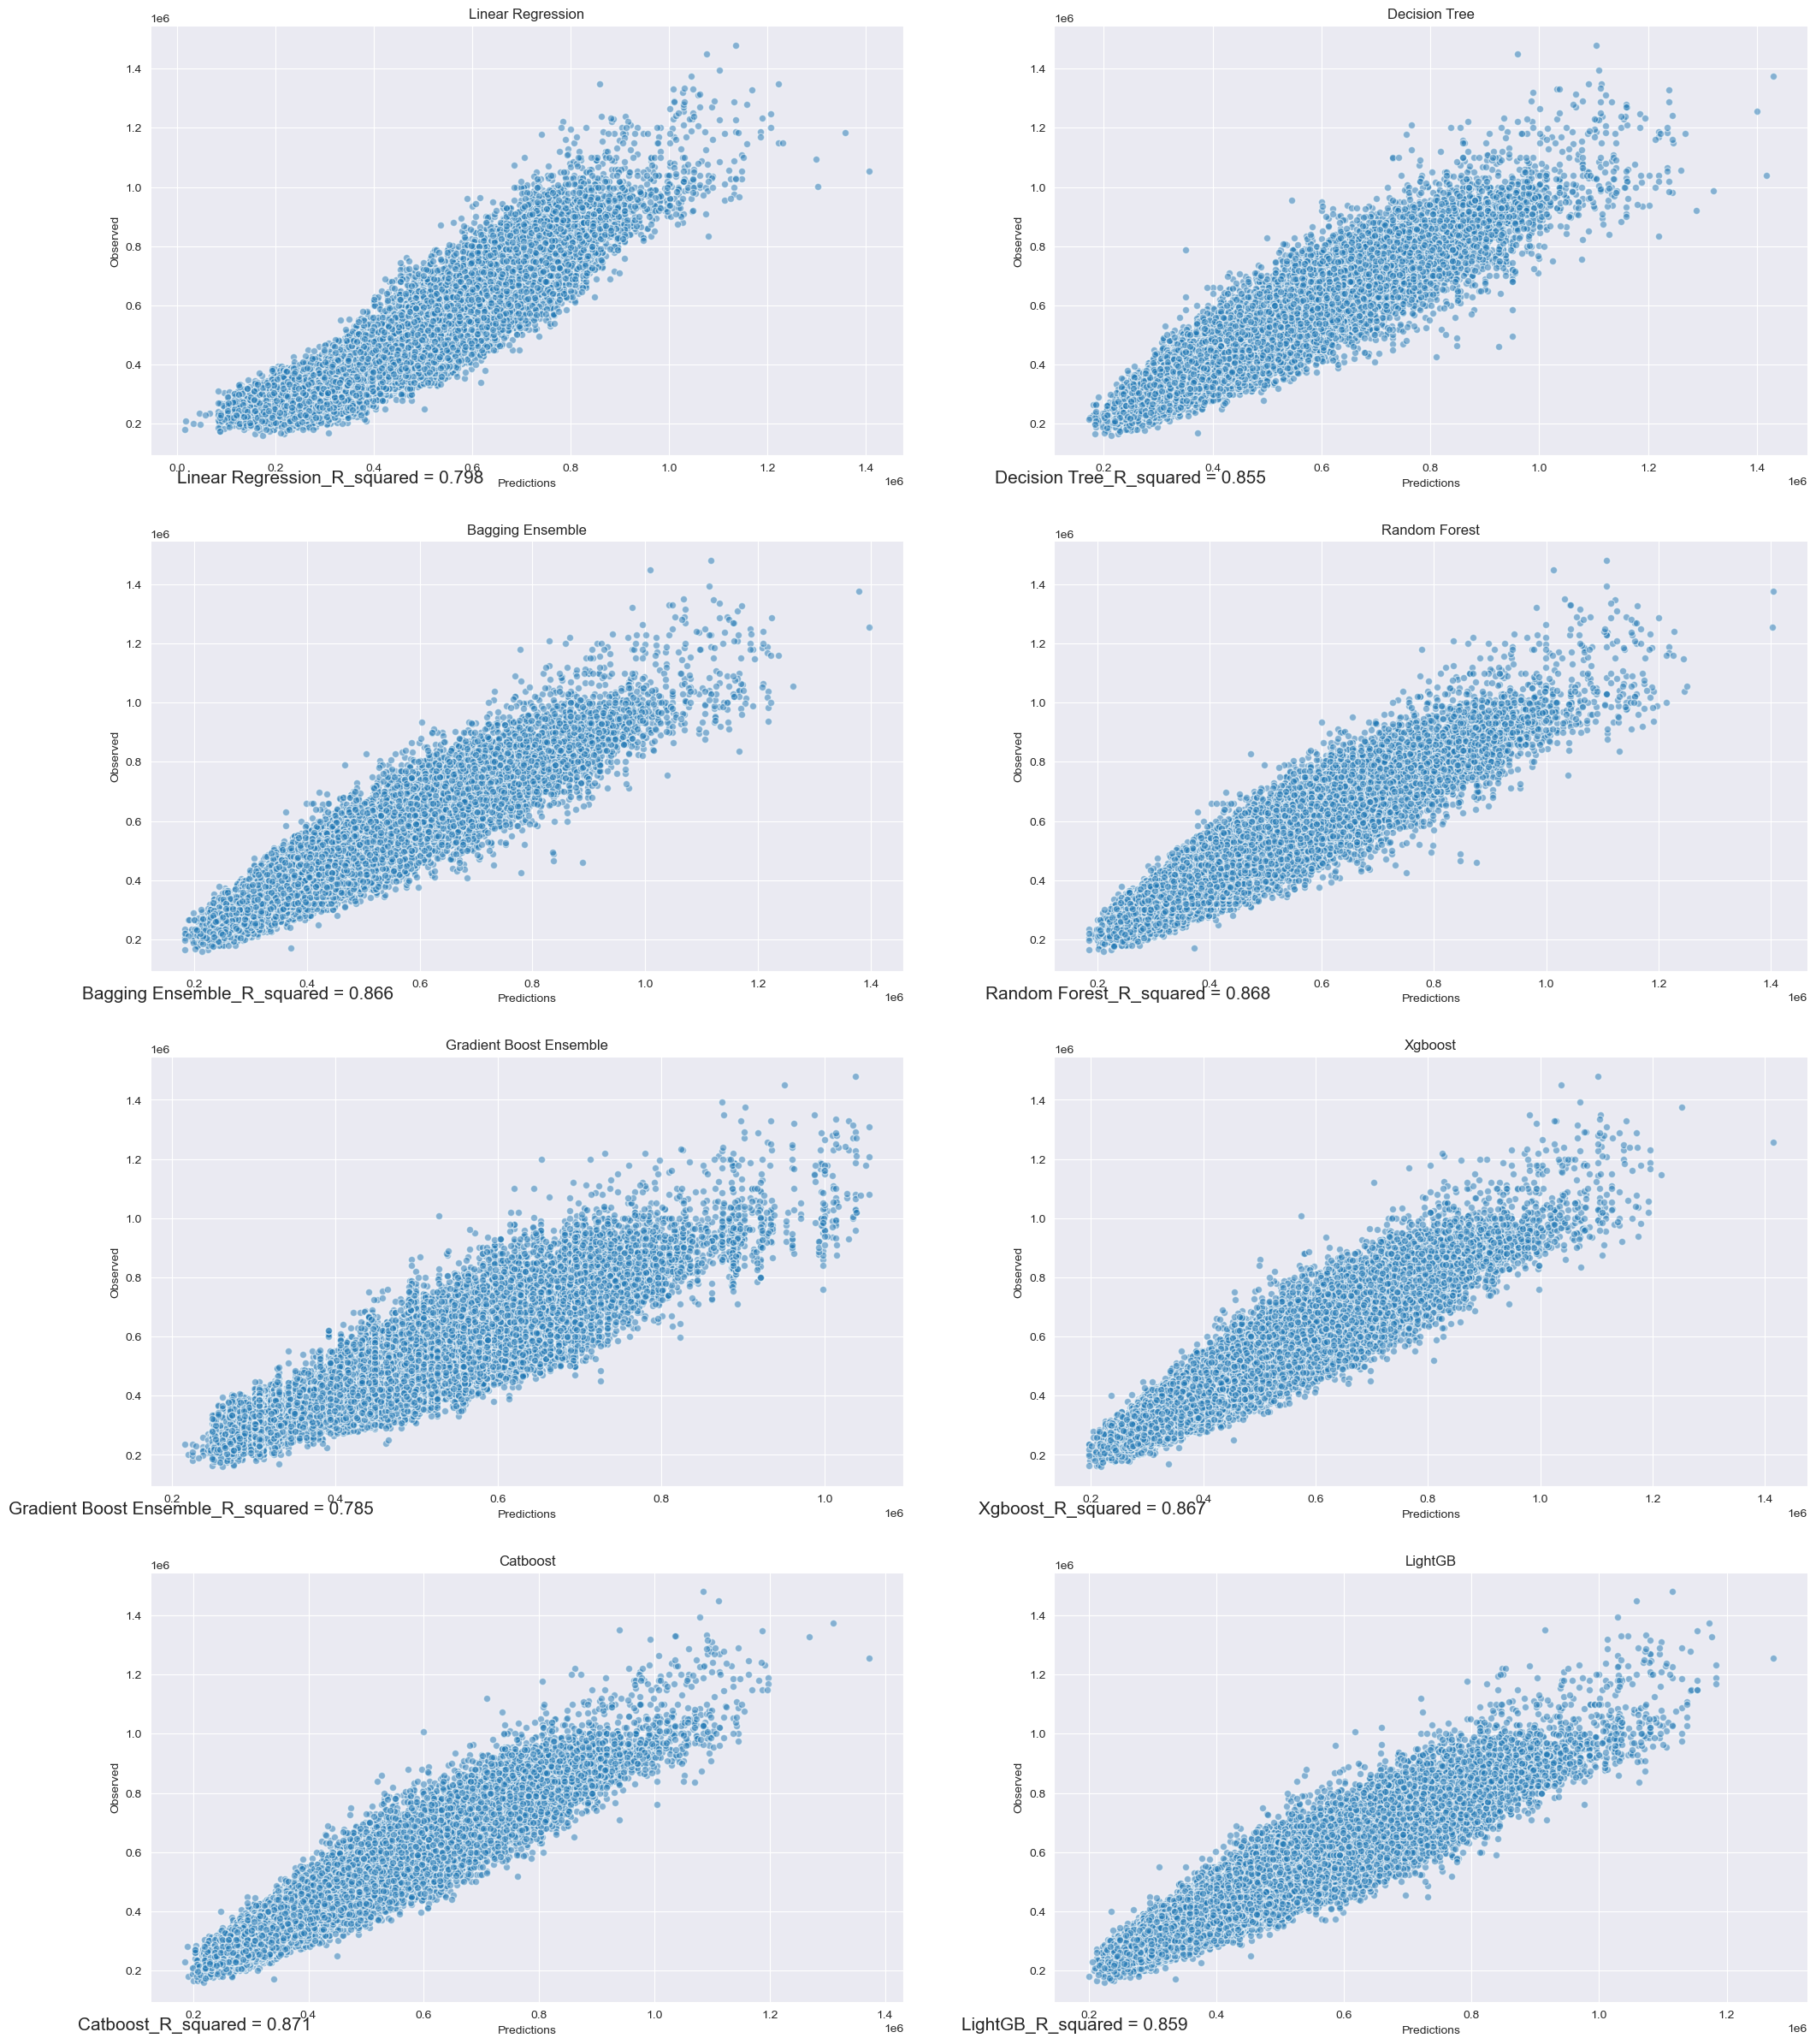

In [22]:
plt.figure(figsize = (25,30))
for pos in range(1,9):
    plt.subplot(4,2,pos)
    plt.scatter(np.array(list(result.values()))[:,-1][pos-1],y_test,alpha=0.5,edgecolors = 'white')
    plt.xlabel('Predictions')
    plt.ylabel('Observed')
    plt.title(list(result.keys())[pos-1])
    plt.text(0,0,f'{list(result.keys())[pos-1]}_R_squared = {round(np.array(list(result.values()))[:,0][pos-1],3)}',
            fontsize = 15)
    
    pos +=1